# Hybrid SWE forecasting: plotting the results

## Target variable analysis (ΔSWE)

After training the models, their predictions for the train, test and augmented data sets are stored. In this section these predicted ΔSWE values are compared to the observed ones.

### Importing the data

In the first code block the user can define for which number of added lagged meteorological features as model input to import the data. In the following block, the dataframes containing true values and model predictions for each simulation mode are stored in nested dictionaries for the temporal and station splits.

In [ ]:
lag = 14    # 0, 14

In [ ]:
import pandas as pd
from config import paths, cfg

def load_pred_vs_true_dfs(split_type):

    # Set the type of split and the paths
    cfg.temporal_split = split_type
    config_name = f"ts_{cfg.temporal_split}_lg_{cfg.lag}"
    paths.results = paths.root / "results" / config_name
    paths.temp = paths.results / "temp"

    # Make a loop for each ML-based mode
    dict_dfs = {}
    for mode in cfg.modes().keys():

        # Make a loop for each split
        split_dict_dfs = {}
        for split in ["trn", "aug", "tst"]:
            
            # Skip the data augmented data if the mode is not data_aug
            if mode != "data_aug" and split == "aug":
                continue
            
            # Load the dataframe and store it in the dictionary
            file_name = f"pred_vs_true_{mode}_{split}.csv"
            df = pd.read_csv(paths.temp / file_name)
            split_dict_dfs[split] = df

        # Store the mode dictionary in the main one
        dict_dfs[mode] = split_dict_dfs
    
    return dict_dfs

# Set the lag
cfg.lag = lag

# Load the dataframes for each split type
tmp_dict_dfs = load_pred_vs_true_dfs(True)
stn_dict_dfs = load_pred_vs_true_dfs(False)

### Predicted vs true plots

The next code blocks display the scatter plots for the predicted and actual ΔSWE values. In the first one, the type of split and the mode to plot can be selected, in the second the colours indicate the split and in the third the colors indicate the point density.

In [49]:
temporal_split = True  # False, True
mode = 'data_aug'       # 'dir_pred', 'post_prc', 'cro_vars', 'data_aug'
colour = 'density'      # 'density', 'split_n'

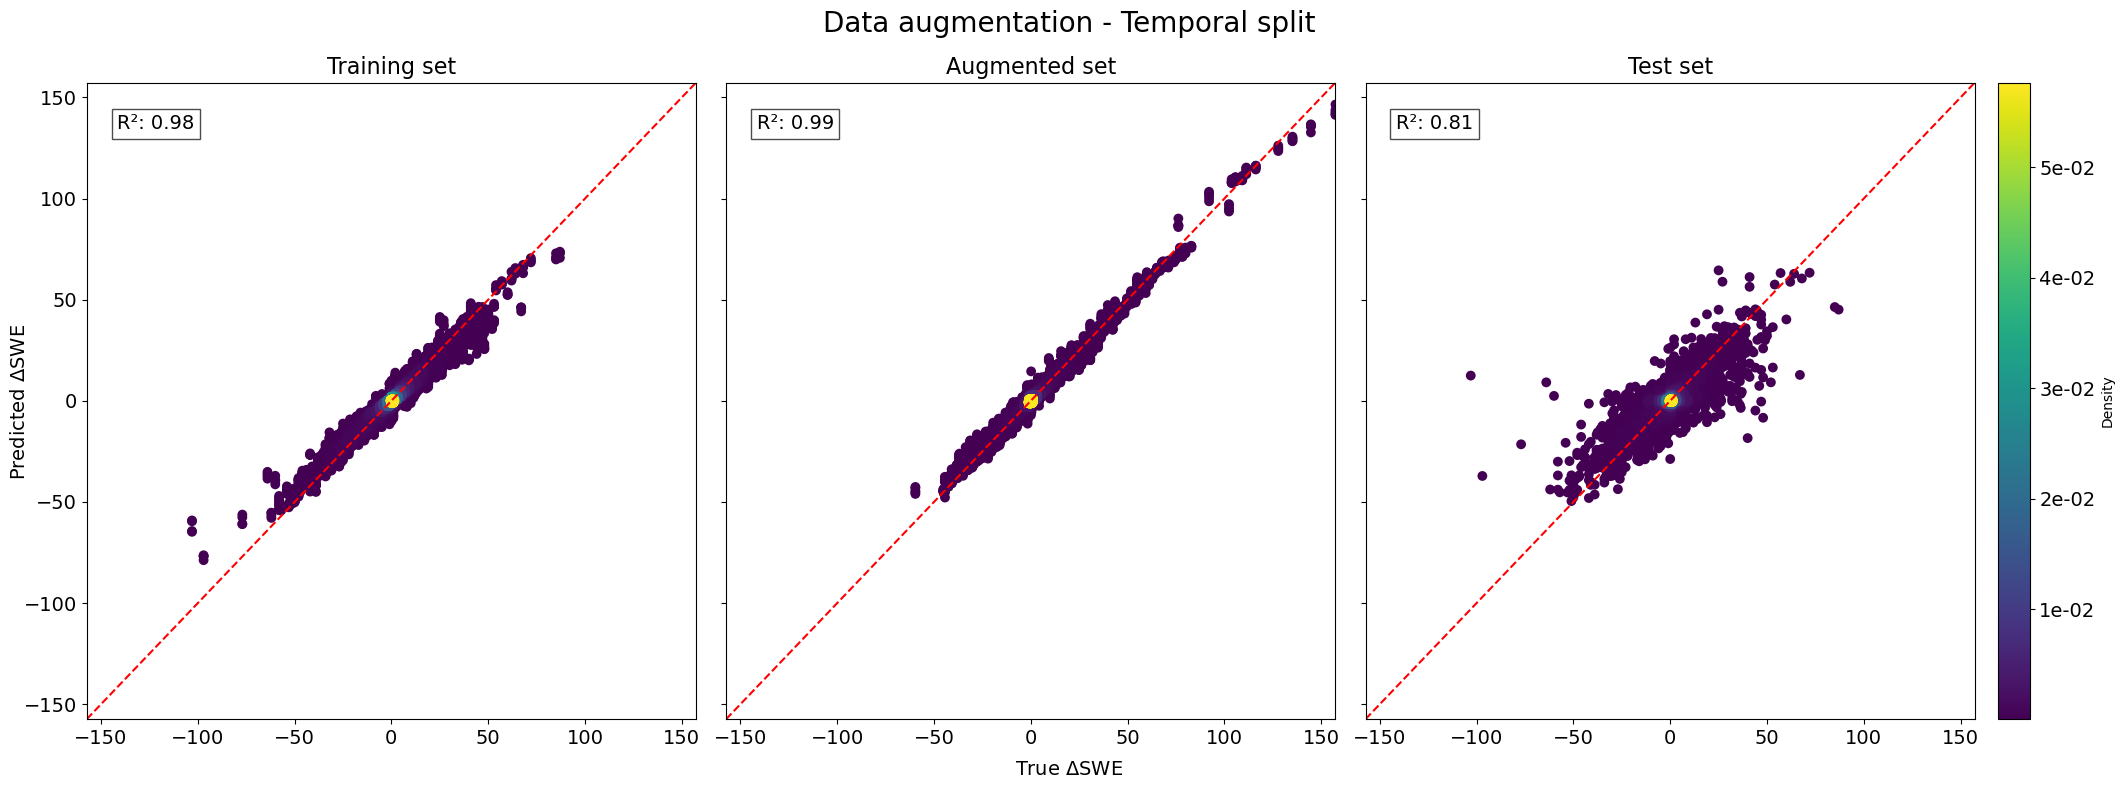

In [50]:
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib import colormaps
import matplotlib.pyplot as plt

# Define the dictionary to use
plot_dict = tmp_dict_dfs if temporal_split else stn_dict_dfs
plot_dict = plot_dict[mode]

# Find the maximum dSWE value in any of the dataframes
max_val = max(df[[f'y_{split}', f'y_{split}_pred']].abs().max().max() for split, df in plot_dict.items())

# Create subplots
fig, axes = plt.subplots(1, len(plot_dict.keys()), figsize=(7*len(plot_dict), 7),
                         sharex=True, sharey=True, constrained_layout=True)
axes = axes.flatten()

for i, split in enumerate(plot_dict.keys()):
    
    # Get the dataframe for the current split and set the axis
    df = plot_dict[split]    
    ax = axes[i]

    # Set the limits for the axis
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val, max_val)

    # Add the colour and x based on user preference
    if colour == 'density':
        if mode == 'data_aug':
            # Use 2D histogram for a fast density approximation
            x = df[f'y_{split}'].values
            y = df[f'y_{split}_pred'].values
            # Define number of bins (adjust as needed)
            bins = 100  
            density_hist, xedges, yedges = np.histogram2d(x, y, bins=bins, density=True)
            # Get indices of the bins each point falls into
            x_idx = np.clip(np.digitize(x, xedges) - 1, 0, len(xedges) - 2)
            y_idx = np.clip(np.digitize(y, yedges) - 1, 0, len(yedges) - 2)
            density_vals = density_hist[x_idx, y_idx]
            
            # Sort the points by density so that the denser points are plotted last
            idx = density_vals.argsort()
            x, y, c = x[idx], y[idx], density_vals[idx]
            cmap = colormaps['viridis']
        else:
            # Calculate the point density
            xy = np.vstack([df[f'y_{split}'], df[f'y_{split}_pred']])
            z = gaussian_kde(xy)(xy)

            # Sort the points by density, so that the densest points are plotted last
            idx = z.argsort()
            x, y, c = df[f'y_{split}'].values[idx], df[f'y_{split}_pred'].values[idx], z[idx]
            cmap = colormaps['viridis']
            
    elif colour == 'split_n':
        x, y, c = df[f'y_{split}'].values, df[f'y_{split}_pred'].values, df['split'].values
        cmap = colormaps['tab20']
    else:
        raise ValueError("The colour parameter must be either 'density' or 'split_n'")

    # Create the scatter plot with color based on the split
    scatter = ax.scatter(x, y, c=c, cmap=cmap, s=50, edgecolor='none')

    # Add a line for perfect prediction
    ax.plot([-max_val, max_val], [-max_val, max_val], color='red', linestyle='--')
    
    # Add a title corresponding to the split
    rename_dict = {"trn": "Training set", "aug": "Augmented set", "tst": "Test set"}
    ax.set_title(f'{rename_dict[split]}', fontsize=16)

    # Calculate the correlation coefficient
    corr = np.corrcoef(x, y)[0, 1]
    ax.text(0.05, 0.95, f'R²: {corr:.2f}', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add a legend for the split names or the density
if colour == 'density':
    fig.colorbar(scatter, ax=axes, label='Density', pad=0.01, format='%.0e')
    y_label_position = 0
else:
    axes[0].legend(handles=scatter.legend_elements()[0], labels = list(df['split'].unique()),
                title='Split', bbox_to_anchor=(-0.075, 1), fontsize=14, title_fontsize=16)
    y_label_position = 0.045
# Add a general label for the axes and a title
fig.text(0.5, -0.025, 'True $\Delta$SWE', ha='center', va='center', fontsize=14)
fig.text(y_label_position, 0.5, 'Predicted $\Delta$SWE', ha='center', va='center', rotation='vertical', fontsize=14)
rename_dict = {"dir_pred": "Measurement-based", "post_prc": "Post-processing",
               "cro_vars": "Post-processing (add. variables)", "data_aug": "Data augmentation"}
fig.suptitle(f"{rename_dict[mode]} - {'Temporal split' if temporal_split else 'Spatial split'}",
             fontsize=20, y=1.06)

# plt.tight_layout()
plt.show()

## Simulation analysis (SWE)

The trained models are used to simulate SWE time series for all the stations and dates with availability of predictor data. If multiple splits are available, for each time step it is ensured that the model for which that time step is part of its test set is used. If multiple are available, the model from the first split is used.

### Importing the data

In the first code block the user can define for which number of added lagged meteorological features as model input to import the data. In the following block, the simulated and observed SWE data along with other meteorological variables are imported for each station and stored in separate dictionaries for the temporal and spatial splits. The NSE values for each of them are also loaded.

In [ ]:
lag = 14    # 0, 14

In [ ]:
import pandas as pd
from config import paths, cfg

def load_swe_simulation_dfs(temporal_split):
    cfg.temporal_split = temporal_split
    config_name = f"ts_{cfg.temporal_split}_lg_{cfg.lag}"
    paths.results = paths.root / "results" / config_name
    paths.temp = paths.results / "temp"
    paths.outputs = paths.results / "outputs"

    data_dict = {}
    for station_name in cfg.station_names:
        # Load the processed data
        filename = f"df_{station_name}_lag_{cfg.lag}.csv"
        df_obs = pd.read_csv(paths.proc_data / filename, index_col=0)

        # Subset the obs and mod SWE columns, as well as temperature and snowfall
        df_obs = df_obs[["obs_swe", "mod_swe", "met_Tair_avg", "met_Snowf_avg"]]

        # Load the ML simulated data
        filename = f"df_{station_name}_pred_swe.csv"
        df_sim = pd.read_csv(paths.temp / filename, index_col=0)

        # Join both dataframes by index
        df_station = df_obs.join(df_sim, how="outer")
        df_station.index = pd.to_datetime(df_station.index)

        # Add the data to the dictionary
        data_dict[station_name] = df_station

        # Load the NSE output
        df_nse = pd.read_csv(paths.outputs / 'fwd_sim_nse.csv', index_col=0)

    return data_dict, df_nse

# Set the lag
cfg.lag = lag

# Load the dataframes for each split type
tmp_dict_dfs, df_nse_tmp = load_swe_simulation_dfs(temporal_split=True)
stn_dict_dfs, df_nse_stn = load_swe_simulation_dfs(temporal_split=False)

### Strip plots (NSE)

In the first code block the user can decide whether to include the post-processing approach with additional Crocus state variables, or to only display the regular version. In the following block, strip plots representing the NSE at each station are plotted for the two split types (temporal and station). The size of the scatter points represents the number of measured SWE data samples in the corresponding station.

In [43]:
include_cro_vars = False  # False, True

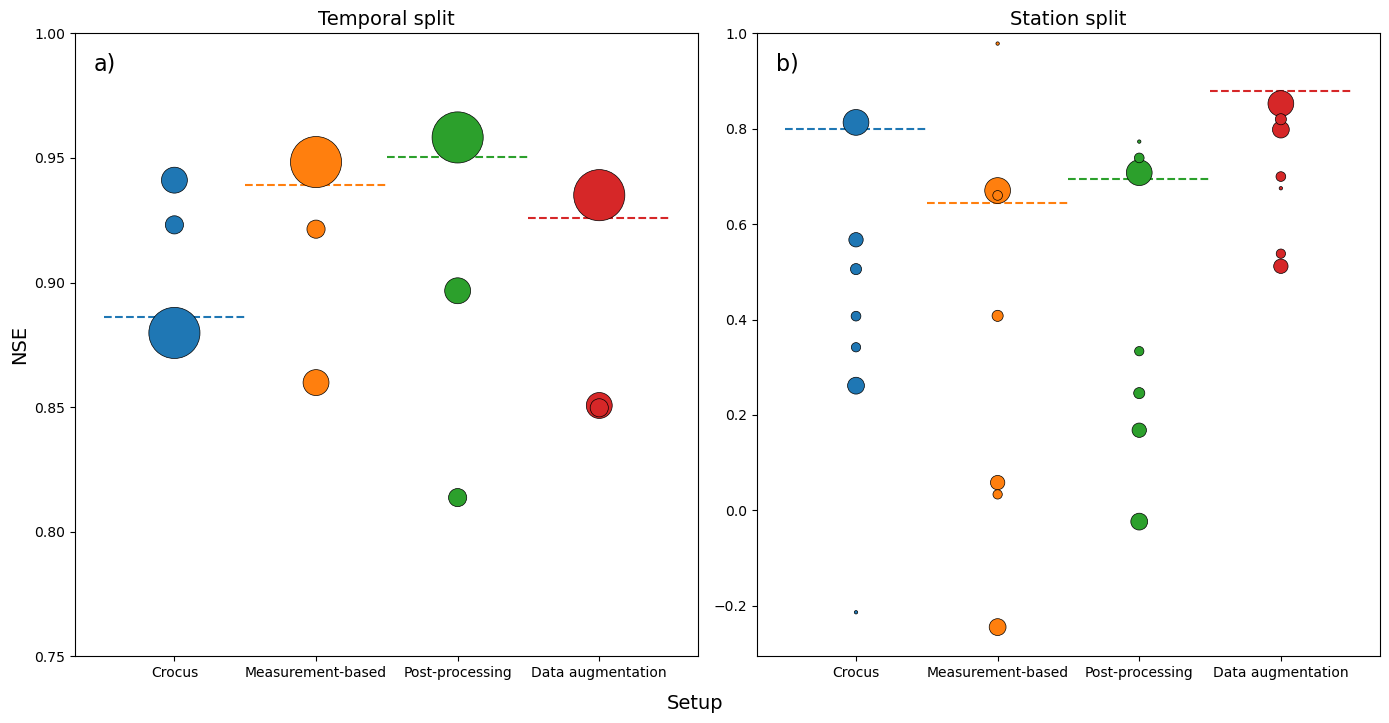

In [45]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14 + 3*include_cro_vars, 7))

for ax, temporal_split in zip(axs, [True, False]):

    # Select the correct dataframe and drop the unnecessary stations
    plot_nse = df_nse_tmp if temporal_split else df_nse_stn
    drop_stations = cfg.tst_stn if temporal_split else cfg.trn_stn
    df_nse_plot = plot_nse[~plot_nse.index.isin(drop_stations)].copy()

    # Remove the cro_vars column if specified
    if not include_cro_vars:
        df_nse_plot = df_nse_plot.drop(columns='cro_vars')

    # Rename the mode names for the plot
    rename_dict = {"mod_swe": "Crocus", "dir_pred": "Measurement-based", "post_prc": "Post-processing",
                "cro_vars": "Post-processing\n(add. variables)", "data_aug": "Data augmentation"}
    df_nse_plot.rename(columns=rename_dict, inplace=True)

    # Store the TEST row separately and remove it from the dataframe
    avg_test_nse = df_nse_plot.loc['TEST']
    df_nse_plot = df_nse_plot.drop('TEST')

    # Sort the dataframe by number of observations in descending order
    df_nse_plot = df_nse_plot.sort_values(by='n', ascending=False)

    # Plot temporal split
    for column_name in df_nse_plot.columns[:-1]:
        scatter = ax.scatter([column_name]*len(df_nse_plot), df_nse_plot[column_name],
                             label=column_name, s=df_nse_plot['n'], edgecolors='black',
                             linewidths=0.5, zorder=2)
        
        # Calculate the x position for the column and plot a horizontal line
        x_pos = df_nse_plot.columns.get_loc(column_name)
        ax.plot([x_pos - 0.5, x_pos + 0.5], [avg_test_nse[column_name]]*2,
                    color=scatter.get_facecolor(), linestyle='--', zorder=1)

# Set the labels and titles
axs[0].set_ylabel('NSE', fontsize=14)
axs[0].set_title('Temporal split', fontsize=14)
axs[0].text(0.03, 0.97, 'a)', transform=axs[0].transAxes, fontsize=16, verticalalignment='top')
axs[0].set_ylim(0.75, 1)
axs[1].set_title('Station split', fontsize=14)
axs[1].text(0.03, 0.97, 'b)', transform=axs[1].transAxes, fontsize=16, verticalalignment='top')
axs[1].set_ylim(top=1)
fig.text(0.5, -0.02, 'Setup', ha='center', fontsize=14)

plt.tight_layout()
plt.show()

### Time series of SWE

This section implements the code for plotting the time series data with all of the simulation modes, as well as the error from the observations and the average temperature and snowfall values.

#### Temporal split

In the first code block the user can decide the station to plot, the starting and end year. In the second block,  the mean absolute error and DTW are calculated and printed. In the last block, the time series are plotted for the temporal split data, in particular for the data-rich stations (`'rme'` is recommended). The results start in September of the starting year and end in June of the end year.

In [42]:
station_name = "rme"    # 'cdp', 'rme', 'sod'
year_start = 1991       # integer
year_end = 1996         # integer, > year_start

In [43]:
import pandas as pd
from fastdtw import fastdtw
from sklearn.metrics import mean_absolute_error

# Select the dataframe to plot
df_plot = tmp_dict_dfs[station_name]
labels = []

# Remove the 'cro_vars' column
if 'cro_vars' in df_plot.columns:
    df_plot = df_plot.drop(columns='cro_vars')

# Mask the measurements, remove the unnecessary columns and clean the data
df_masked = mask_measurements_by_year_range(df_plot, year_start, year_end)
df_masked = df_masked.drop(columns=['met_Tair_avg', 'met_Snowf_avg'])
df_masked_clean = df_masked.dropna()

# Create a renaming dictionary for each mode
rename_dict = {'mod_swe': 'Crocus simulation', 'dir_pred': 'Measurement-based',
               'post_prc': 'Post-processing', 'data_aug': 'Data-augmentation'}

# Initialize a list to store the results
results = []

# Calculate and print the DTW distance and MAE for each mode
for column_name in df_masked_clean.columns:

    # Skip the observed SWE column
    if column_name == 'obs_swe':
        continue

    # Gather the observed and simulated values
    obs = df_masked_clean['obs_swe'].values
    sim = df_masked_clean[column_name].values

    # Calculate the DTW distance and MAE
    mae = mean_absolute_error(obs, sim)
    distance, path = fastdtw(obs, sim, dist=2)

    # Store the results in the list
    results.append({
        'Mode': rename_dict[column_name],
        'DTW Distance': distance / len(obs),
        'MAE': mae
    })

# Convert the results list to a DataFrame and set the mode as the index
results_df = pd.DataFrame(results)
results_df.set_index('Mode', inplace=True)
results_df

DTW Distance        MAE
Mode                                      
Crocus simulation      5.350567  19.458427
Measurement-based      6.028400  17.685528
Post-processing        5.877646  16.823357
Data-augmentation      6.756989  19.312042

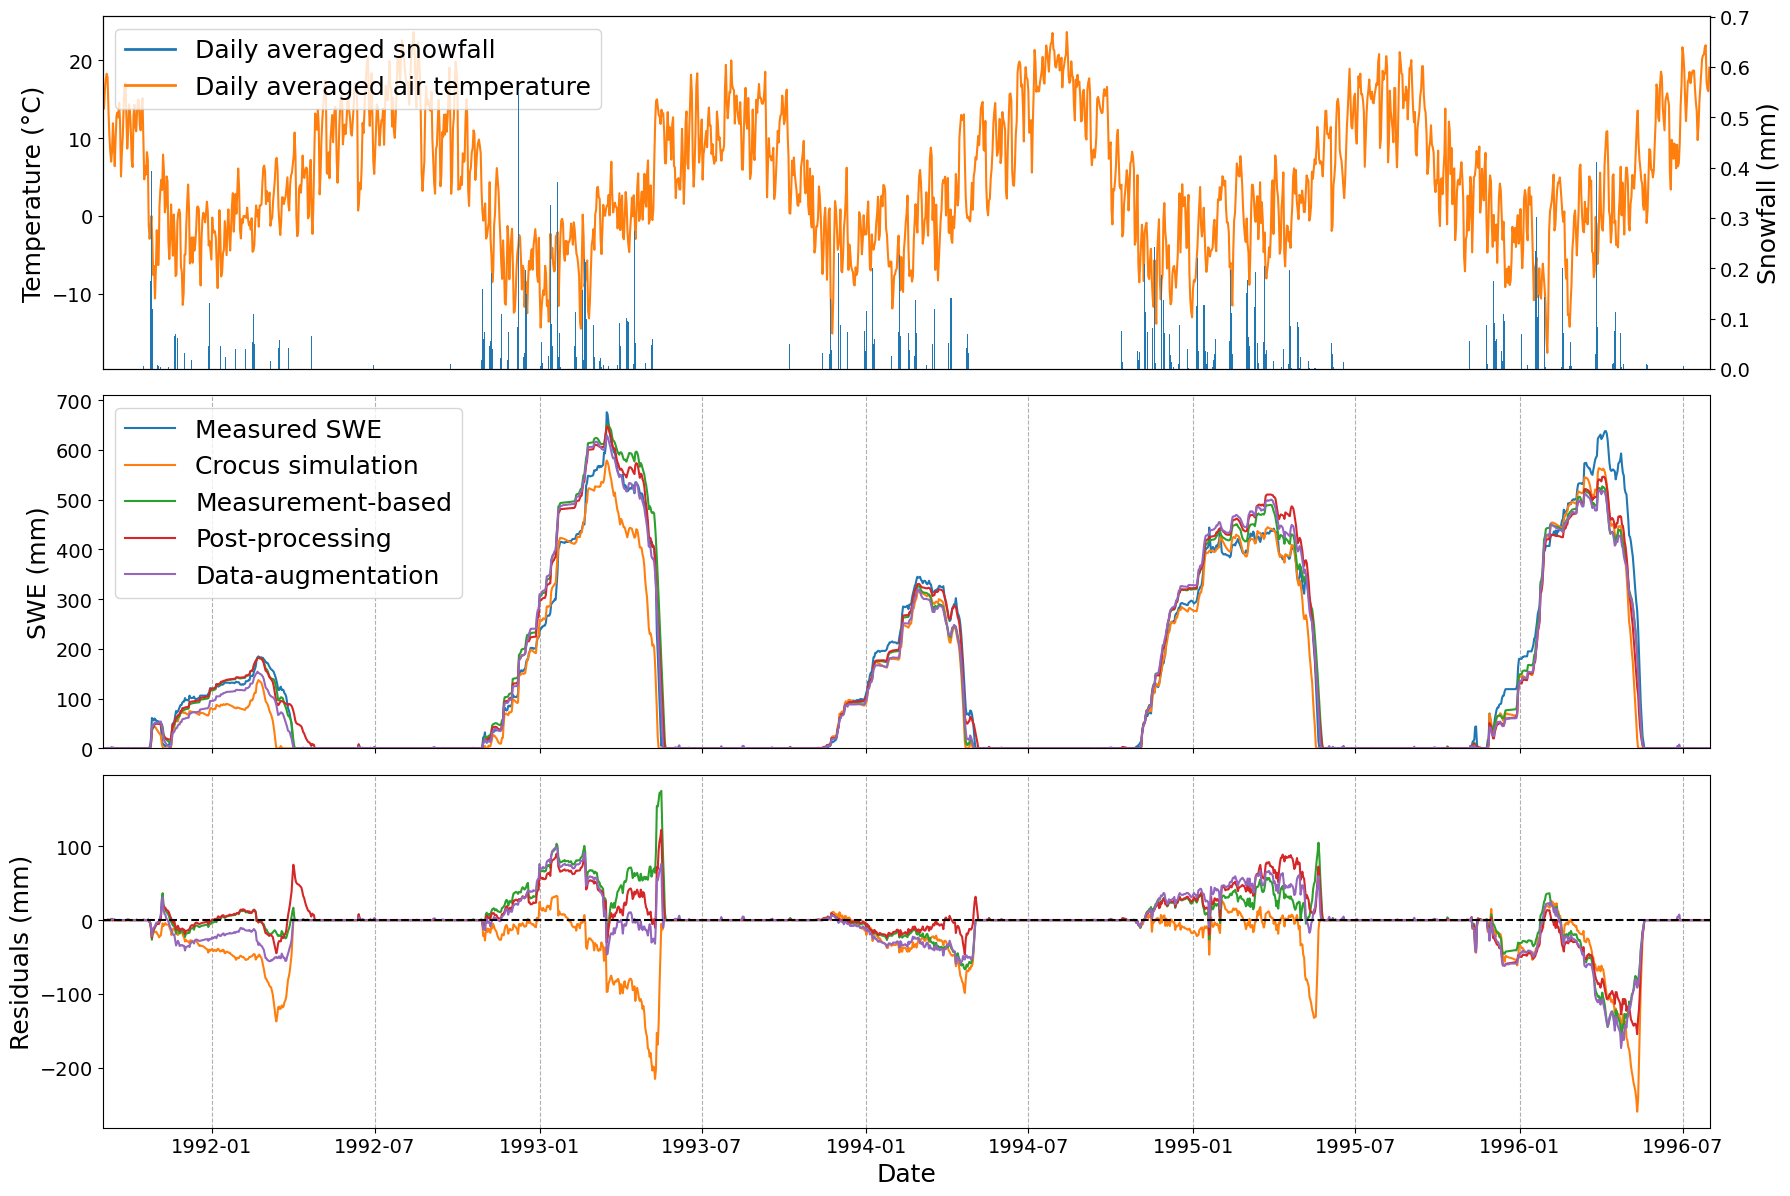

In [44]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Select the dataframe to plot
df_plot = tmp_dict_dfs[station_name]
labels = []

# Remove the 'cro_vars' column
if 'cro_vars' in df_plot.columns:
    df_plot = df_plot.drop(columns='cro_vars')

# Mask the measurements by the start and end year
mask = ((df_plot.index.year == year_start) & (df_plot.index.month >= 9)) | \
        ((df_plot.index.year == year_end) & (df_plot.index.month <= 7)) | \
        ((df_plot.index.year > year_start) & (df_plot.index.year < year_end))
df_masked = df_plot[mask]

# Store the temperature and snowfall columns separately
df_temp_snow = df_masked[['met_Tair_avg', 'met_Snowf_avg']]
df_masked = df_masked.drop(columns=['met_Tair_avg', 'met_Snowf_avg'])

# Rename the columns in the masked dataframe
rename_dict = {'obs_swe': 'Measured SWE', 'mod_swe': 'Crocus simulation', 'dir_pred': 'Measurement-based',
               'post_prc': 'Post-processing', 'data_aug': 'Data-augmentation'}
df_masked = df_masked.rename(columns=rename_dict)

# Create the figure and subplots
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3, sharex=ax2)

# Set the axis tick size for all the figure
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

# Plot the snowfall and temperature in the first subplot
snowf_plot = df_temp_snow["met_Snowf_avg"].plot(ax=ax1, kind='bar', secondary_y=True)
next(ax1._get_lines.prop_cycler)
temp_plot = df_temp_snow["met_Tair_avg"].plot(ax=ax1, use_index=False)

# Set the labels and ticks
ax1.set_ylabel('Temperature (°C)', fontsize=18)
ax1.right_ax.set_ylabel('Snowfall (mm)', fontsize=18)
ax1.tick_params(axis='y', labelsize=14)
ax1.right_ax.tick_params(axis='y', labelsize=14)

# Create proxy artists and display the legend
snowf_proxy = Line2D([0], [0], color=snowf_plot.patches[0].get_facecolor(), lw=2, label='Daily averaged snowfall')
temp_proxy = Line2D([0], [0], color=temp_plot.lines[0].get_color(), lw=2, label='Daily averaged air temperature')
ax1.legend(handles=[snowf_proxy, temp_proxy], fontsize=18, loc='upper left')

# Remove the x-axis ticks
ax1.set_xticks([])

# Plot the masked data in the second subplot
for column_name in df_masked.columns:
    ax2.plot(df_masked[column_name], label=f'{column_name}')

# Create proxy artists and display the legend
handles, labels = ax2.get_legend_handles_labels()
handles.append(Line2D([0], [0], marker='None', color='white'))
ax2.legend(handles=handles, labels=labels, fontsize=18, loc='upper left')

# Set the labels and axis limits
ax2.set_ylabel('SWE (mm)', fontsize=18)
ax2.set_xlim(df_masked.index[0], df_masked.index[-1])
ax2.set_ylim(0)

# Remove the minor x-ticks and add grid lines
ax2.xaxis.set_minor_locator(plt.NullLocator())
ax2.grid(axis='x', linestyle='--')

# Plot the error from each method in the third subplot
for column_name in df_masked.columns:
    if column_name == 'Measured SWE':
        next(ax3._get_lines.prop_cycler)
        continue
    error = df_masked[column_name] - df_masked["Measured SWE"]
    ax3.plot(error)

# Plot a horizontal line at 0
ax3.axhline(0, color='black', linestyle='--')

# Set the labels and add the grid lines
ax3.set_xlabel('Date', fontsize=18)
ax3.set_ylabel('Residuals (mm)', fontsize=18)
ax3.grid(axis='x', linestyle='--')

plt.tight_layout()
plt.show()

#### Station split

In the first code block the user can decide the station to plot, the starting and end year. The results start in September of the starting year and end in June of the end year. In the following block, the time series data is plotted for the station split data, in particular for the test stations. In this plot, the measured SWE (and errors) are represented with dots and only within each year they are connected by a line for easier visual interpretation. 

In [39]:
station_name = "wfj"
year_start = 2009
year_end = 2014

In [40]:
from fastdtw import fastdtw
from sklearn.metrics import mean_absolute_error

# Select the dataframe to plot
df_plot = stn_dict_dfs[station_name]
labels = []

# Remove the 'cro_vars' column
if 'cro_vars' in df_plot.columns:
    df_plot = df_plot.drop(columns='cro_vars')

# Mask the measurements, remove the unnecessary columns and clean the data
df_masked = mask_measurements_by_year_range(df_plot, year_start, year_end)
df_masked = df_masked.drop(columns=['met_Tair_avg', 'met_Snowf_avg'])
df_masked_clean = df_masked.dropna()

# Create a renaming dictionary for each mode
rename_dict = {'mod_swe': 'Crocus simulation', 'dir_pred': 'Measurement-based',
               'post_prc': 'Post-processing', 'data_aug': 'Data-augmentation'}

# Initialize a list to store the results
results = []

# Calculate and print the DTW distance and MAE for each mode
for column_name in df_masked_clean.columns:

    # Skip the observed SWE column
    if column_name == 'obs_swe':
        continue

    # Gather the observed and simulated values
    obs = df_masked_clean['obs_swe'].values
    sim = df_masked_clean[column_name].values

    # Calculate the DTW distance and MAE
    mae = mean_absolute_error(obs, sim)
    distance, path = fastdtw(obs, sim, dist=2)

    # Store the results in the list
    results.append({
        'Mode': rename_dict[column_name],
        'DTW Distance': distance / len(obs),
        'MAE': mae
    })

# Convert the results list to a DataFrame and set the mode as the index
results_df = pd.DataFrame(results)
results_df.set_index('Mode', inplace=True)
results_df

DTW Distance         MAE
Mode                                       
Crocus simulation     63.491335  105.061353
Measurement-based     80.491416  119.402581
Post-processing       77.527650  118.215093
Data-augmentation     58.811590   95.206907

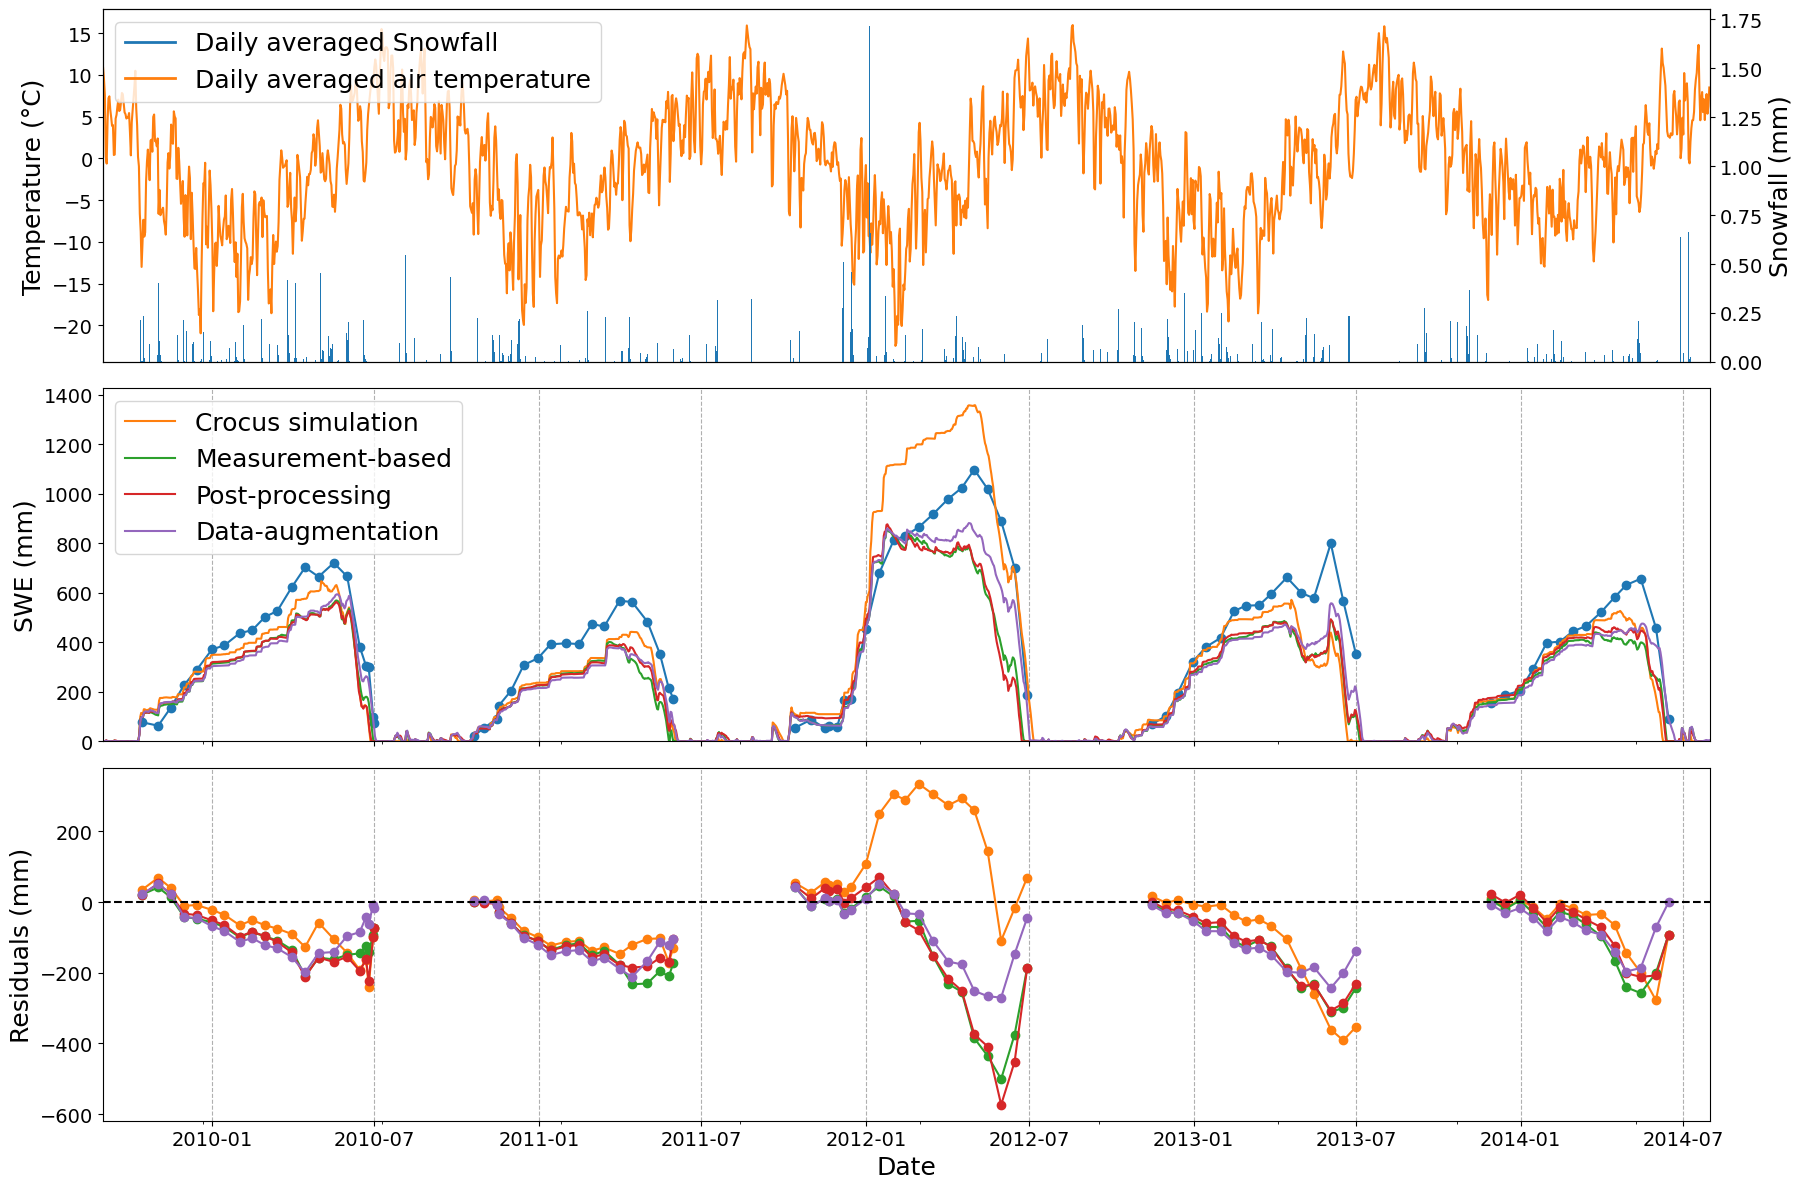

In [41]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Create a dictionary with the dataframes to plot, and a list of labels
df_plot = stn_dict_dfs[station_name]
labels = []

# Remove the 'cro_vars' column
if 'cro_vars' in df_plot.columns:
    df_plot = df_plot.drop(columns='cro_vars')

# Mask the measurements by the start and end year
mask = ((df_plot.index.year == year_start) & (df_plot.index.month >= 9)) | \
        ((df_plot.index.year == year_end) & (df_plot.index.month <= 7)) | \
        ((df_plot.index.year > year_start) & (df_plot.index.year < year_end))
df_masked = df_plot[mask]

# Store the temperature and snowfall columns separately
df_temp_snow = df_masked[['met_Tair_avg', 'met_Snowf_avg']]
df_masked = df_masked.drop(columns=['met_Tair_avg', 'met_Snowf_avg'])

# Rename the columns in the masked dataframe
rename_dict = {'obs_swe': 'Measured SWE', 'mod_swe': 'Crocus simulation', 'dir_pred': 'Measurement-based',
               'post_prc': 'Post-processing', 'data_aug': 'Data-augmentation'}
df_masked = df_masked.rename(columns=rename_dict)

# Create the figure and subplots
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3, sharex=ax2)

# Plot the snowfall and temperature in the first subplot
snowf_plot = df_temp_snow["met_Snowf_avg"].plot(ax=ax1, kind='bar', secondary_y=True)
next(ax1._get_lines.prop_cycler)
temp_plot = df_temp_snow["met_Tair_avg"].plot(ax=ax1, use_index=False)

# Set the labels and ticks
ax1.set_ylabel('Temperature (°C)', fontsize=18)
ax1.right_ax.set_ylabel('Snowfall (mm)', fontsize=18)
ax1.tick_params(axis='y', labelsize=14)
ax1.right_ax.tick_params(axis='y', labelsize=14)

# Create proxy artists and display the legend
snowf_proxy = Line2D([0], [0], color=snowf_plot.patches[0].get_facecolor(), lw=2, label='Daily averaged Snowfall')
temp_proxy = Line2D([0], [0], color=temp_plot.lines[0].get_color(), lw=2, label='Daily averaged air temperature')
ax1.legend(handles=[snowf_proxy, temp_proxy], fontsize=18, loc='upper left')

# Remove the x-axis ticks
ax1.set_xticks([])

# Get the color cycle
color_cycle = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Plot the masked data for each column in the second subplot
for idx, column_name in enumerate(df_masked.columns):

    # Drop the NaN values and select the color
    clean_column = df_masked[column_name].dropna()
    color = color_cycle[(idx)]

    # Plot the measured data as dots connected by lines only within each snow year
    if column_name == 'Measured SWE':

        # Find the snow year of each date
        clean_swe = clean_column.to_frame(name='Measured SWE')
        clean_swe['year'] = (clean_swe.index  + pd.DateOffset(months=5)).year

        # Plot the data separately for each snow year
        for year, group in clean_swe.groupby('year'):
            ax2.plot(group.index, group['Measured SWE'], linestyle='-', marker='o', color=color)
        next(ax2._get_lines.prop_cycler)

    else:
        ax2.plot(clean_column, label=f'{column_name}')

# Create the legend
handles, labels = ax2.get_legend_handles_labels()
handles.append(Line2D([0], [0], marker='None', color='white'))
ax2.legend(handles=handles, labels=labels, fontsize=18, loc='upper left')

# Set axis limits
ax2.set_ylim(0)
ax2.set_xlim(df_masked.index[0], df_masked.index[-1])

# Add the axis labels and a dashed grid
ax2.set_ylabel('SWE (mm)', fontsize=18)
ax2.grid(axis='x', linestyle='--')

# Plot the error from each method in the third subplot
for idx, column_name in enumerate(df_masked.columns):

    # Skip the observed SWE column
    if column_name == 'Measured SWE':
        continue

    # Calculate the error and store it in a DataFrame
    error = df_masked[column_name] - df_masked["Measured SWE"]
    error = error.to_frame(name='error')

    # Find the snow year of each date
    error['year'] = (error.index + pd.DateOffset(months=5)).year
    
    # Plot the data separately for each snow year
    color = color_cycle[(idx % len(color_cycle))]
    for year, group in error.groupby('year'):
        group = group.dropna()
        ax3.plot(group.index, group['error'], linestyle='-', marker='o', color=color)

# Plot a horizontal line at 0
ax3.axhline(0, color='black', linestyle='--')

# Set the labels and add the grid lines
ax3.set_xlabel('Date', fontsize=18)
ax3.set_ylabel('Residuals (mm)', fontsize=18)
ax3.grid(axis='x', linestyle='--')

plt.tight_layout()
plt.show()

## Feature importances

Using the same predictor data as for the simulations, the feature importances are retrieved for each simulation mode using the `shap` library.

### Importing the data

In the first code block the user can define for which type of split to import the data. In the following block, a dictionary contatining a SHAP explainer for each mode is created after loading the three components required to build it.

In [112]:
lag = 14                # 0, 14

In [113]:
import pandas as pd
import shap
from config import paths, cfg

def load_shap_explanation(temporal_split):
    # Set the temp directory for the correct split
    config_name = f"ts_{temporal_split}_lg_{cfg.lag}"
    paths.results = paths.root / "results" / config_name
    paths.temp = paths.results / "temp"

    # Initialize a list to store the explanations
    explanations = {}

    # Load the explanations for each mode
    for mode in cfg.modes().keys():
        
        # Load the saved CSV files
        shap_values = pd.read_csv(paths.temp / 'shap_explanations' / f'df_{mode}_shap.csv')
        base_values = pd.read_csv(paths.temp / 'shap_explanations' / f'df_{mode}_base.csv')
        data = pd.read_csv(paths.temp / 'shap_explanations' / f'df_{mode}_data.csv')
        
        # Drop the split_idx column
        shap_values = shap_values.drop(columns='split_idx').values
        base_values = base_values.drop(columns='split_idx').values
        data = data.drop(columns='split_idx').values

        # Load the processed data to get the column names
        df = pd.read_csv(paths.proc_data / f'df_cdp_lag_{cfg.lag}.csv', index_col=0)
        df_train_vars = df.filter(regex=cfg.modes()[mode])
        columns = df_train_vars.columns.tolist()
        
        # Create an explanation object from the loaded values and store it in the dict
        explanation = shap.Explanation(shap_values, base_values.squeeze(), data, feature_names=columns)
        explanations[mode] = explanation

    return explanations

# Set the lag and type of split
cfg.lag = lag

# Load the SHAP explanations for each split type
tmp_explanations = load_shap_explanation(temporal_split=True)
stn_explanations = load_shap_explanation(temporal_split=False)

c:\Users\4946057\Miniconda3\envs\project_4946057\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Top feature importances

To compare the feature importances, the mean absolute SHAP value is calculated for all data points. The absolute SHAP value of the lagged version of a variable are aggregated on a data point basis to provide an overview of the variable impact. To sort the feature importances, the average feature importance for the three main ML-based modes is calculated. For those features, the importances from the three modes are displayed in a bar plot.

In [13]:
temporal_split = True  # False, True

In [14]:
import re
import numpy as np

# Select the dictionary to use and remove the cro_vars column
explanations = tmp_explanations if temporal_split else stn_explanations
explanations = {mode: explanation for mode, explanation in explanations.items() if mode != 'cro_vars'}

# Create a dataframe to store the importances for each mode
feature_names = explanations['post_prc'].feature_names
feature_names_agg = [re.sub(r'_lag_\d+', '', feature) for feature in feature_names]
fi_agg_lag = pd.DataFrame(index=list(set(feature_names_agg)))

# Iterate over each mode and its explanation
for mode, explanation in explanations.items():

    # Remove the lag from the feature names
    feature_names_mode = explanation.feature_names
    feature_names_mode = [re.sub(r'_lag_\d+', '', feature) for feature in feature_names_mode]
    unique_features = set(feature_names_mode)
    feature_agg_dict = {feature: np.zeros((len(explanation))) for feature in unique_features}

    # Sum the rows that share the same feature name
    for feature, shap_values in zip(feature_names_mode, explanation.values.T):
        feature_agg_dict[feature] += np.abs(shap_values)

    # Obtain the mean absolute SHAP values for each feature
    mean_importance = {feature: agg_shap_values.mean() for feature, agg_shap_values in feature_agg_dict.items()}

    # Append the results to the dataframe as a new column
    df = pd.DataFrame(mean_importance, index=[mode]).T
    fi_agg_lag = pd.concat([fi_agg_lag, df], axis=1)

# Add a column with the mean importance across all modes
fi_agg_lag['mean'] = fi_agg_lag.mean(1)

# Sort the dataframe by the mean importance
fi_agg_lag = fi_agg_lag.sort_values('mean', ascending=False)
fi_agg_lag.head(10)

dir_pred  post_prc  data_aug      mean
met_SWdown_int  6.291330  3.934208  3.599666  4.608401
obs_swe         3.182273  0.745908  4.839198  2.922460
met_Tair_int    2.895763  2.807337  1.638271  2.447124
met_Tair_avg    2.733313  2.913920  1.609505  2.418912
met_Snowf_avg   2.267254  2.179080  2.014977  2.153771
delta_mod_swe        NaN  1.196146       NaN  1.196146
met_Qair_dav    0.790487  0.678212  1.019127  0.829275
met_Qair_avg    0.671403  0.568300  1.002859  0.747521
met_LWdown_dav  0.868748  0.665289  0.658731  0.730923
met_LWdown_int  0.748038  0.612755  0.561134  0.640642

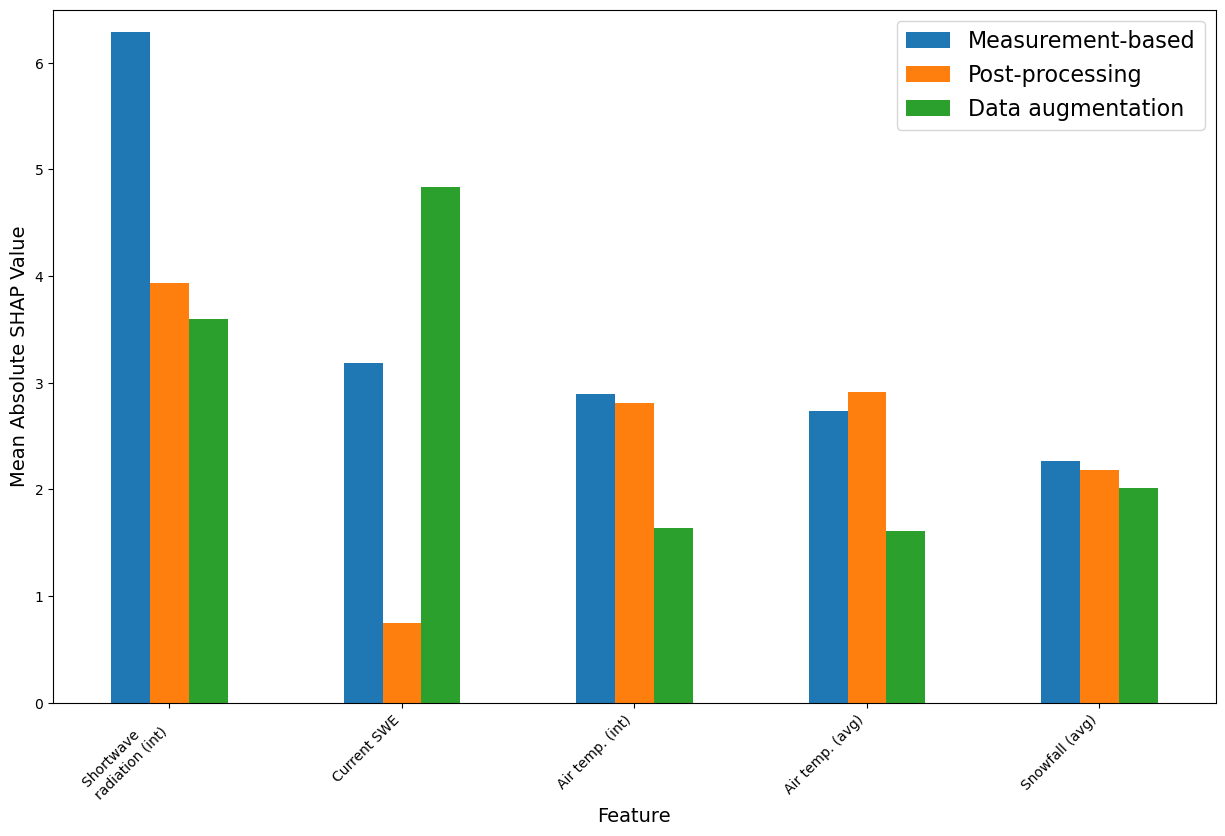

In [15]:
import matplotlib.pyplot as plt

# Make a bar plot of the top 5 most important features
fig, ax = plt.subplots(figsize=(15, 9))

# Plot the importances of the top 5 features for each mode
fi_no_mean = fi_agg_lag.copy().drop(columns=['mean'])
rename_cols = {'dir_pred': 'Measurement-based',
               'post_prc': 'Post-processing',
               'data_aug': 'Data augmentation'}
fi_no_mean = fi_no_mean.rename(columns=rename_cols)
rename_rows = {'met_Snowf_avg': 'Snowfall (avg)',
               'met_Tair_avg': 'Air temp. (avg)',
               'met_Tair_int': 'Air temp. (int)',
               'met_SWdown_int': 'Shortwave     \nradiation (int)',
               'obs_swe': 'Current SWE'}
fi_no_mean = fi_no_mean.rename(index=rename_rows)
fi_no_mean.head(5).plot(kind='bar', ax=ax)

# Add the axis labels
ax.set_xlabel('Feature', fontsize=14)
ax.set_ylabel('Mean Absolute SHAP Value', fontsize=14)

# Make the x tick labels diagonal and set the axis limits
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 6.5)

# Increase the font size of the legend
plt.legend(fontsize=16)

plt.show()

#### Lag importances

To analyse the impact of the lagged variables, their mean absolute SHAP values displayed in the following plot for the top features.

In [16]:
# Create a dataframe to store the importances for each mode
feature_names = explanations['post_prc'].feature_names
feature_importances = pd.DataFrame(index=feature_names)

# Iterate over each mode and its explanation
for mode, explanation in explanations.items():

    # Calculate the mean absolute SHAP values for each feature
    feature_importances_mode = explanation.abs.mean(0).values
    feature_names_mode = explanation.feature_names

    # Append the results to the dataframe as a new column
    df = pd.DataFrame(feature_importances_mode, index=feature_names_mode, columns=[mode])
    feature_importances = pd.concat([feature_importances, df], axis=1)

# Add a column with the mean importance across all modes
feature_importances['mean'] = feature_importances.mean(1)

# Sort the dataframe by the mean importance
feature_importances = feature_importances.sort_values('mean', ascending=False)
feature_importances.head(10)

dir_pred  post_prc  data_aug      mean
obs_swe               3.182273  0.745908  4.839198  2.922460
met_Snowf_avg         2.028356  1.992303  1.764598  1.928419
met_Tair_int          1.956566  1.885077  1.065902  1.635848
met_Tair_avg          1.870583  1.998204  1.027040  1.631943
met_SWdown_int        2.318693  0.862213  1.489321  1.556742
delta_mod_swe              NaN  1.196146       NaN  1.196146
met_SWdown_int_lag_1  1.274848  0.680997  0.628114  0.861320
met_SWdown_int_lag_2  0.725477  0.509471  0.393401  0.542783
met_Tair_int_lag_1    0.476904  0.530625  0.270559  0.426030
met_Tair_avg_lag_1    0.458541  0.468603  0.293961  0.407035

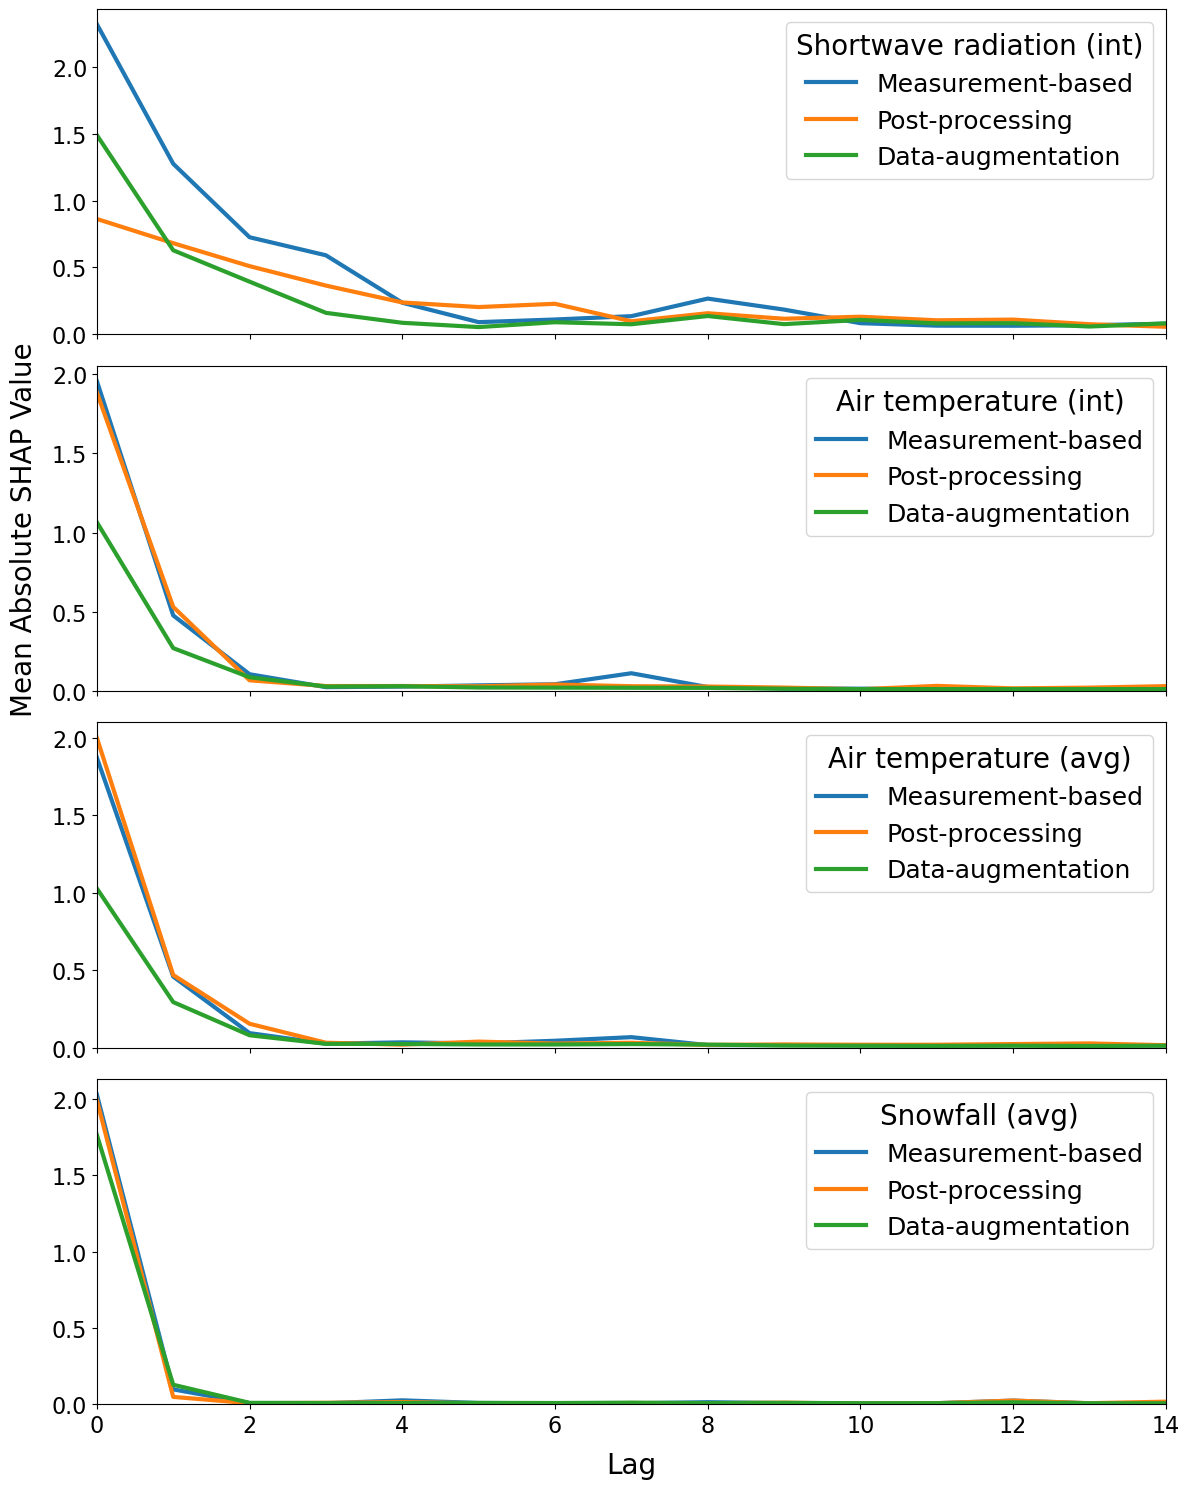

In [17]:
# From the FI dataframe, get the top 5 most important features by mean
top_features = fi_agg_lag['mean'].sort_values(ascending=False).head(5).index

# Obtain a different df for each feature and all of its lagged versions
dfs = {}
for feature in top_features:

    # Skip the observed SWE feature
    if feature == 'obs_swe':
        continue
    
    # Obtain the rows that match the feature name
    contains_feature = feature_importances.index.str.contains(feature)
    dfs[feature] = feature_importances[contains_feature].copy()
    dfs[feature] = dfs[feature].drop(columns='mean')

    # Find the lag values for each row
    lag_values = []
    for index in dfs[feature].index:
        if re.search(r'_lag_\d+', index):
            lag = int(re.search(r'_lag_(\d+)', index).group(1))
        else:
            lag = 0
        lag_values.append(lag)

    # Set the lag values as the index and sort the dataframe
    dfs[feature].index = lag_values
    dfs[feature] = dfs[feature].sort_index()

    # Rename the mode names
    rename_dict = {'dir_pred': 'Measurement-based',
                     'post_prc': 'Post-processing',
                     'data_aug': 'Data-augmentation'}
    
    dfs[feature] = dfs[feature].rename(columns=rename_dict)


# Rename the feature keys in the dictionary
rename_dict = {'met_Snowf_avg': 'Snowfall (avg)',
               'met_Tair_avg': 'Air temperature (avg)',
               'met_Tair_int': 'Air temperature (int)',
               'met_SWdown_int': 'Shortwave radiation (int)'}
dfs = {rename_dict[key]: value for key, value in dfs.items()}

# Make a figure with as many subplots as there are features
fig, axs = plt.subplots(4, 1, figsize=(12, 15), sharex=True)

# Plot the SHAP dependence plots for each feature
for i, (feature, df) in enumerate(dfs.items()):
    if i > 3:
        break
    ax = axs[i]
    df.plot(kind='line', ax=ax, lw=3)
    if i ==1:
        ax.set_ylabel('Mean Absolute SHAP Value', fontsize=20, labelpad=10)
    ax.set_xlabel('Lag', fontsize=20, labelpad=10)

    # Add a title to the legend
    legend = ax.legend(title=feature, fontsize=18, title_fontsize=20)

    # Set the axis limits
    ax.set_xlim(0, 14)
    ax.set_ylim(0)

    # Increase the font size of the ticks
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Set max 5 ticks on the y-axis
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))


plt.tight_layout()
plt.show()

### Dependence plots

The SHAP library allows to make scatter plots where the SHAP values of a given feature are displayed against the value of that feature for each data point. Three interesting examples are presented:

#### Snowfall

The following plot shows how snowfall affects the change in SWE in each of the models. A positive linear relationship is expected.

In [114]:
temporal_split = False  # False, True

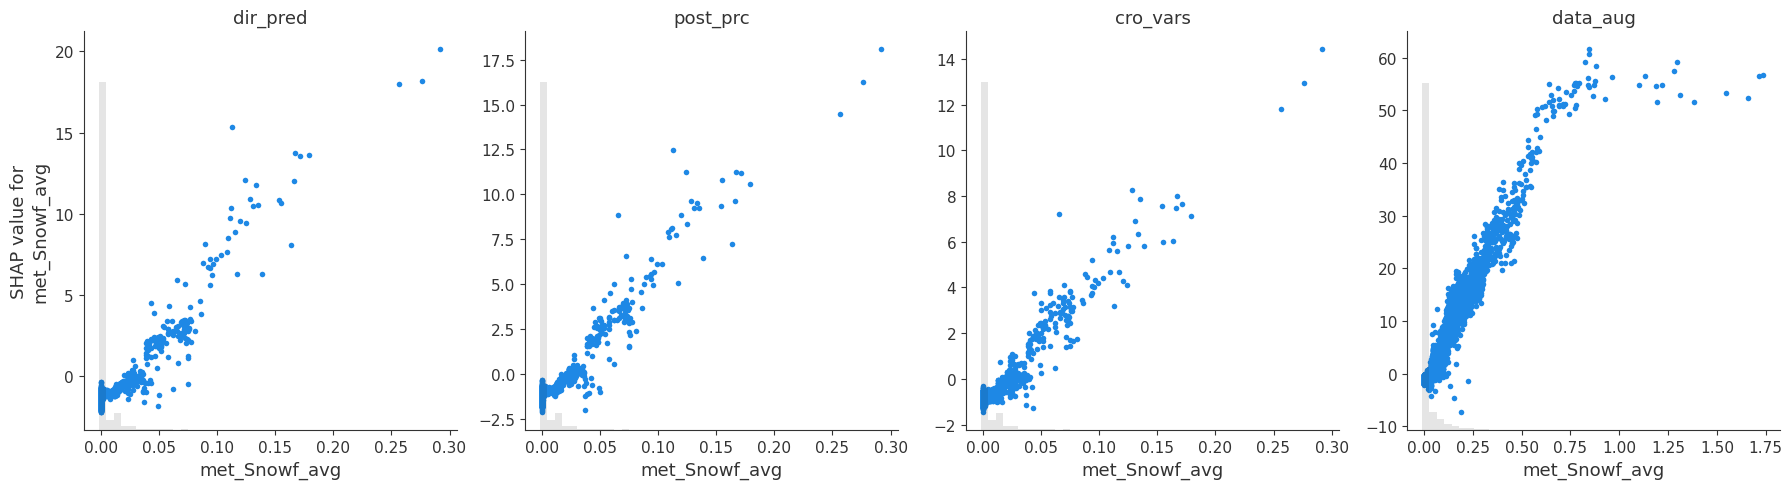

In [115]:
# Select the dictionary to use
explanations = tmp_explanations if temporal_split else stn_explanations

# Create a figure with as many subplots as there are modes
fig, axs = plt.subplots(1, len(explanations), figsize=(18,5))

# Plot the SHAP dependence plots for each mode
for i, (mode, explanation) in enumerate(explanations.items()):
    shap.plots.scatter(explanation[:, 'met_Snowf_avg'], title=mode, show=False, ax=axs[i])
    if i != 0:
        axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

#### Current SWE

In [ ]:
temporal_split = True  # False, True

The following plot shows the relationship between current SWE and future change in SWE for each model. The color indicates the value of the variable that better helps explain the spread in the predictions, calculated automatically by the SHAP library.

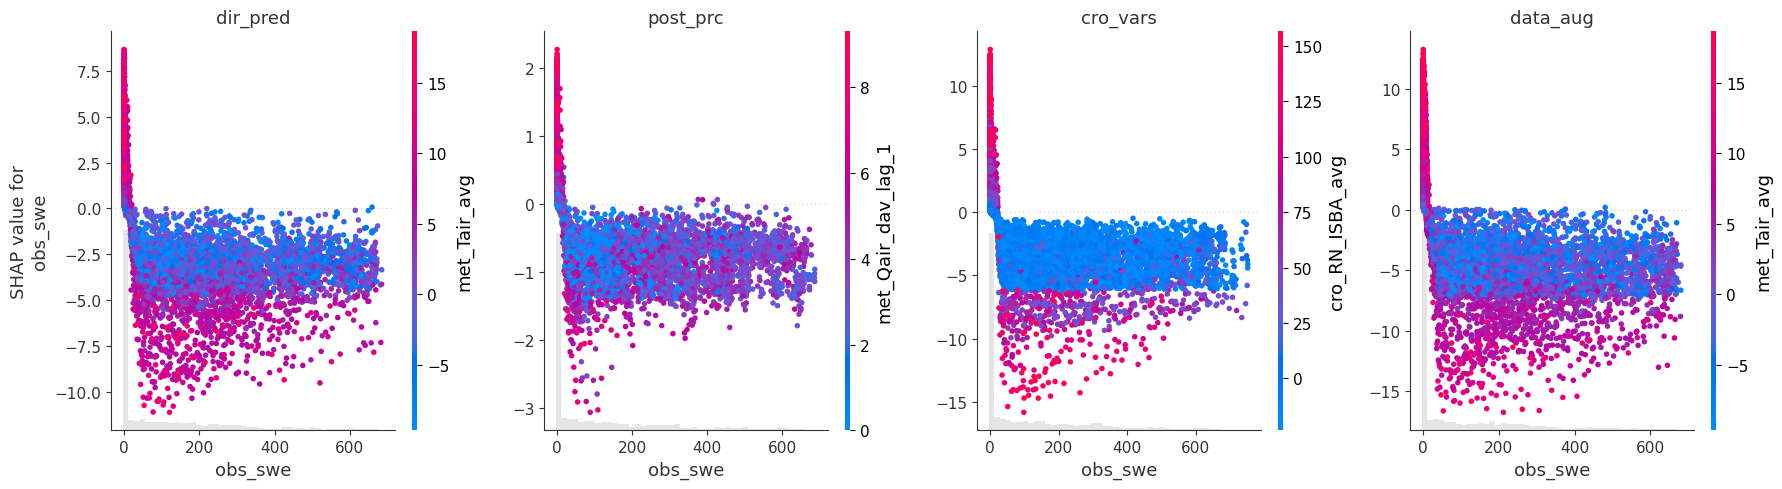

In [ ]:
# Select the dictionary to use
explanations = tmp_explanations if temporal_split else stn_explanations

# Create a figure with as many subplots as there are modes
fig, axs = plt.subplots(1, len(explanations), figsize=(18,5))

# Plot the SHAP dependence plots for each mode
for i, (mode, explanation) in enumerate(explanations.items()):
    shap.plots.scatter(explanation[:, 'obs_swe'], explanation,
                        title=mode, show=False, ax=axs[i])
    if i != 0:
        axs[i].set_ylabel('')
        
plt.tight_layout()
plt.show()

#### Crocus 

In the last example, the influence of the net radiation feature from Crocus (in post-processing with additional variables) is compared to the influence of the measured shortwave radiations in the other modes for the station split, which is potentially the cause for its subpar performance.

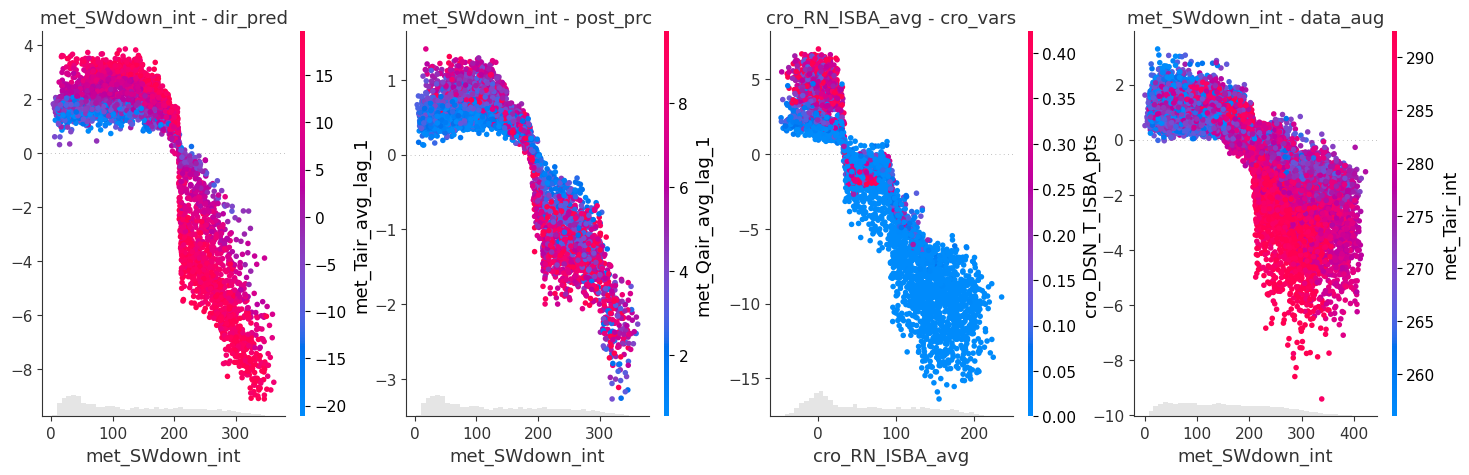

In [25]:
explanations = stn_explanations

# Create a figure with as many subplots as there are modes
fig, axs = plt.subplots(1, len(explanations), figsize=(18,5))

for i, (mode, explanation) in enumerate(explanations.items()):
    
    if mode == 'cro_vars':
        # Plot the SHAP dependence plot for the crocus net radiation feature    
        explanation = explanations['cro_vars']
        shap.plots.scatter(explanation[:, 'cro_RN_ISBA_avg'], explanation,
                           title=f"cro_RN_ISBA_avg - {mode}", show=False, ax=axs[i])

    else:
        shap.plots.scatter(explanation[:, 'met_SWdown_int'], explanation,
                           title=f"met_SWdown_int - {mode}", show=False, ax=axs[i])
    axs[i].set_ylabel('')

## Additional plots

In [2]:
lag = 14    # 0, 14

In [3]:
import pandas as pd
from config import paths, cfg

def load_swe_simulation_dfs(temporal_split):
    cfg.temporal_split = temporal_split
    config_name = f"ts_{cfg.temporal_split}_lg_{cfg.lag}"
    paths.results = paths.root / "results" / config_name
    paths.temp = paths.results / "temp"
    paths.outputs = paths.results / "outputs"

    data_dict = {}
    for station_name in cfg.station_names:
        # Load the processed data
        filename = f"df_{station_name}_lag_{cfg.lag}.csv"
        df_obs = pd.read_csv(paths.proc_data / filename, index_col=0)

        # Subset the obs and mod SWE columns, as well as temperature and snowfall
        df_obs = df_obs[["obs_swe", "mod_swe", "met_Tair_avg", "met_Snowf_avg"]]

        # Load the ML simulated data
        filename = f"df_{station_name}_pred_swe.csv"
        df_sim = pd.read_csv(paths.temp / filename, index_col=0)

        # Join both dataframes by index
        df_station = df_obs.join(df_sim, how="outer")
        df_station.index = pd.to_datetime(df_station.index)

        # Add the data to the dictionary
        data_dict[station_name] = df_station

        # Load the NSE output
        df_nse = pd.read_csv(paths.outputs / 'fwd_sim_nse.csv', index_col=0)

    return data_dict, df_nse

# Set the lag
cfg.lag = lag

# Load the dataframes for each split type
tmp_dict_dfs, _ = load_swe_simulation_dfs(temporal_split=True)
stn_dict_dfs, _ = load_swe_simulation_dfs(temporal_split=False)

In [ ]:
import numpy as np

# Define the metrics
def absolute_error(sim, obs):
    return np.abs(sim - obs)

def relative_error(sim, obs):
    denominator = np.abs(obs.where(obs != 0, sim))
    both_zero = (sim == 0) & (obs == 0)
    return np.where(both_zero, 0, np.abs(sim - obs) / denominator)

def symmetric_relative_error(sim, obs):
    denominator = np.maximum(np.abs(obs), np.abs(sim))
    both_zero = (sim == 0) & (obs == 0)
    return np.where(both_zero, 0, np.abs(sim - obs) / denominator)

def bias(sim, obs):
    return sim - obs

def relative_bias(sim, obs):
    denominator = np.abs(obs.where(obs != 0, sim))
    both_zero = (sim == 0) & (obs == 0)
    return np.where(both_zero, 0, (sim - obs) / denominator)

def temporal_absolute_error(sim_dates, obs_dates):
    return np.abs((sim_dates - obs_dates).dt.days)

def temporal_bias(sim_dates, obs_dates):
    return (sim_dates - obs_dates).dt.days
    

### Seasonality of errors

#### Monthly SWE

In [79]:
cfg.temporal_split = False

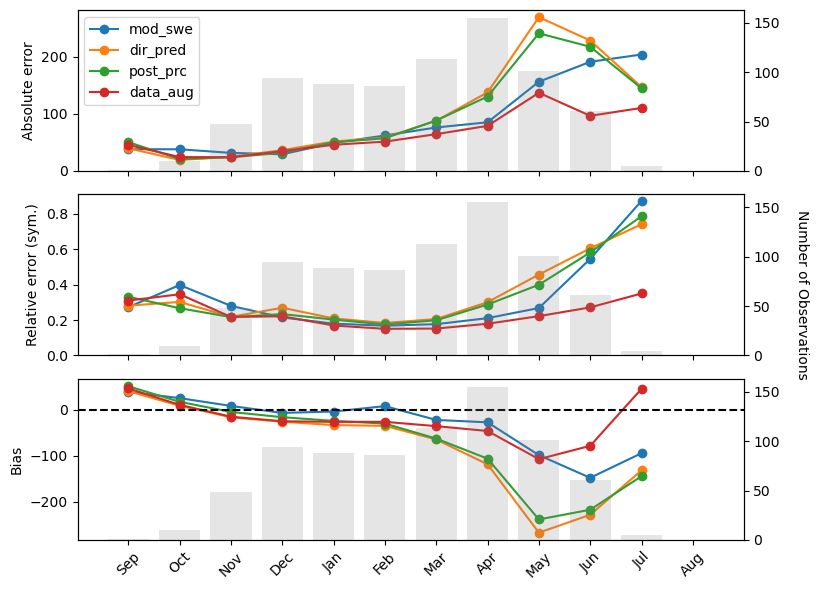

In [107]:
import matplotlib.pyplot as plt
import calendar

# Define the metrics to use and their names
metrics = {'Absolute error': absolute_error,
           'Relative error (sym.)': symmetric_relative_error,
           'Bias': bias}

def calculate_monthly_metric(df, function):

    # Initialize an empty dictionary to store the results
    metric = {}

    # Calculate the metric for each mode
    for column_name in df.columns:
        if column_name == 'obs_swe':
            continue
        metric[column_name] = function(df[column_name], df['obs_swe'])

    # Convert the dictionary to a DataFrame and average the results by month
    df_metric = pd.DataFrame(metric, index=df.index)
    df_monthly_metric = df_metric.groupby(df_metric.index.month).mean()

    # Reorder the index to start from July
    df_monthly_metric = df_monthly_metric.reindex([9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8])

    return df_monthly_metric

# Get the test data
if cfg.temporal_split:
    df_test = pd.concat([df for stn, df in tmp_dict_dfs.items() if stn in cfg.trn_stn])
else:
    df_test = pd.concat([df for stn, df in stn_dict_dfs.items() if stn in cfg.tst_stn])

# Drop the rows with missing values and keep only the modes that are needed
df_clean = df_test.dropna()
df_clean = df_clean[['obs_swe', 'mod_swe', 'dir_pred', 'post_prc', 'data_aug']]

# Obtain the number of measurements by month and reorder the index
obs_count = df_clean['obs_swe'].groupby(df_clean.index.month).count()
obs_count = obs_count.reindex([9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8], fill_value=0)

# Map numerical month values to month names and reorder to start from July
months = [calendar.month_abbr[i] for i in range(9, 13)] + \
         [calendar.month_abbr[i] for i in range(1, 9)]

# Plot the results
fig, axs = plt.subplots(len(metrics), 1, figsize=(8, 2*len(metrics)), sharex=True)

# Calculate the monthly metrics
for ax, (metric_name, function) in zip(axs, metrics.items()):
    df_monthly = calculate_monthly_metric(df_clean, function)

    # Plot the results
    for column_name in df_monthly.columns:
        ax.plot(months, df_monthly[column_name], label=column_name, marker='o')

    # Set the labels and ticks
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)

    # Plot the histogram of the number of observations in the background
    axt = ax.twinx()
    axt.bar(months, obs_count, alpha=0.2, color='gray')

    # Add a horizontal line at 0 if the metric is a bias
    if 'bias' in metric_name.lower():
        ax.axhline(0, color='black', linestyle='--')

    # Set 0 as the lower limit for the y-axis if the metric is an error
    if 'error' in metric_name.lower():
        ax.set_ylim(bottom=0)

    # Add a legend in the first subplot
    if ax == axs[0]:
        ax.legend()

# Add a common secondary y-axis label
fig.text(1, 0.5, 'Number of Observations', va='center', rotation=-90)

# Set a tight layout and show the plot
plt.tight_layout()
plt.show()

#### Daily ΔSWE

In [ ]:
plot_quantiles = True  # False, True

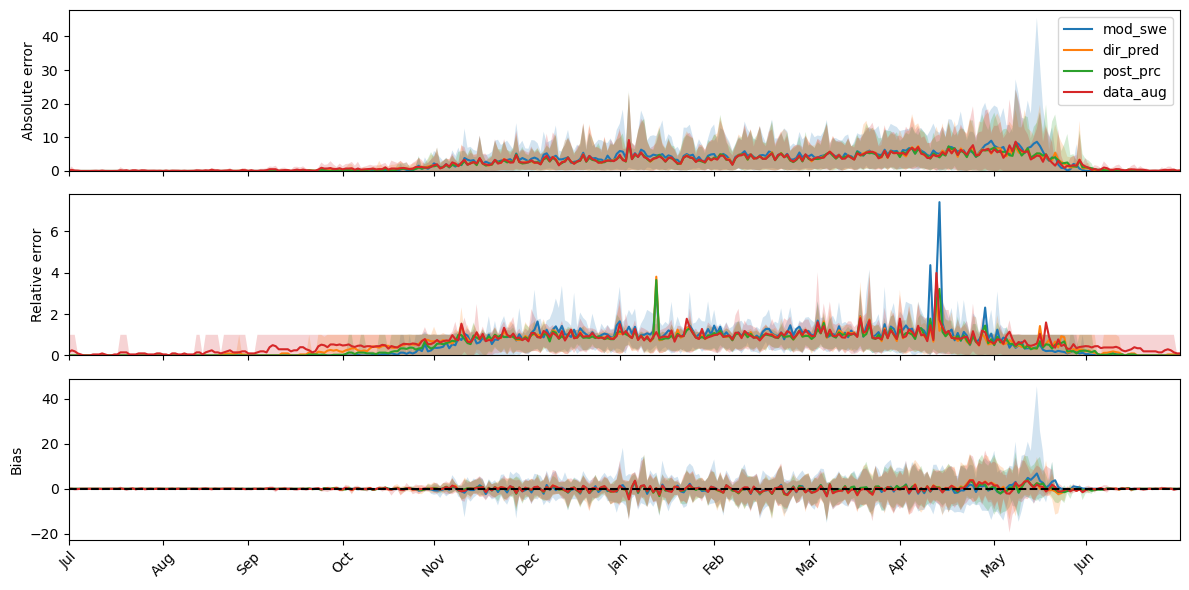

In [ ]:
import matplotlib.pyplot as plt
import calendar

# Define the metrics to use and their names
metrics = {'Absolute error': absolute_error,
           'Relative error': relative_error,
           'Bias': bias}

# Get the data for the test stations
dfs_test = []
for station in cfg.trn_stn:
    df_stn = tmp_dict_dfs[station]
    df_stn = df_stn[['obs_swe', 'mod_swe', 'dir_pred', 'post_prc', 'data_aug']]
    df_dswe_stn = df_stn.diff().shift(-1)[:-1]
    df_clean = df_dswe_stn.dropna()
    dfs_test.append(df_clean)

# Concatenate the dataframes
df_dswe = pd.concat(dfs_test)

def calculate_daily_metric(df, function):

    # Initialize an empty dictionary to store the results
    metric = {}

    # Calculate the metric for each mode
    for column_name in df.columns:
        if column_name == 'obs_swe':
            continue
        metric[column_name] = function(df[column_name], df['obs_swe'])

    # Convert the dictionary to a DataFrame and average the results by day of the year
    df_metric = pd.DataFrame(metric, index=df.index)
    df_daily_metric = df_metric.groupby(df_metric.index.dayofyear).mean()
    df_daily_max = df_metric.groupby(df_metric.index.dayofyear).quantile(0.90)
    df_daily_min = df_metric.groupby(df_metric.index.dayofyear).quantile(0.10)

    # Reorder the index to start from July
    df_daily_metric = df_daily_metric.reindex(list(range(182, 367))+list(range(1, 182)))
    df_daily_max = df_daily_max.reindex(list(range(182, 367))+list(range(1, 182)))
    df_daily_min = df_daily_min.reindex(list(range(182, 367))+list(range(1, 182)))

    # Set the index to a string format
    df_daily_metric.index = df_daily_metric.index.astype(str)
    df_daily_max.index = df_daily_max.index.astype(str)
    df_daily_min.index = df_daily_min.index.astype(str)

    return df_daily_metric, df_daily_max, df_daily_min

# Plot the results
fig, axs= plt.subplots(len(metrics), 1, figsize=(12, 2*len(metrics)), sharex=True)

# Calculate the daily metrics
for ax, (metric_name, function) in zip(axs, metrics.items()):
    df_daily_res, df_daily_res_max, df_daily_res_min = calculate_daily_metric(df_dswe, function)

    # Plot the results
    for column_name in df_daily_res.columns:
        ax.plot(df_daily_res.index, df_daily_res[column_name], label=column_name)
        if plot_quantiles:
            ax.fill_between(df_daily_res_min.index, df_daily_res_min[column_name], df_daily_res_max[column_name], alpha=0.2)

    # Set the labels and ticks
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlim([0, 365])
    ax.set_xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
    ax.set_xticklabels(calendar.month_abbr[7:13] + calendar.month_abbr[1:7])

    # Add a horizontal line at 0 if the metric is a bias
    if 'bias' in metric_name.lower():
        ax.axhline(0, color='black', linestyle='--')

    # Set 0 as the lower limit for the y-axis if the metric is an error
    if 'error' in metric_name.lower():
        ax.set_ylim(bottom=0)

    # Add a legend in the first subplot
    if ax == axs[0]:
        ax.legend()

# Set a tight layout and show the plot
plt.tight_layout()
plt.show()

### Peak SWE

In [103]:
temporal_split = True  # False, True
plot_quantiles = True   # False, True

In [104]:
# Gather the data for all test stations and the selected mode
if temporal_split:
    dict_test = {station_name: tmp_dict_dfs[station_name] for station_name in cfg.trn_stn}
    min_obs = 100
else:
    dict_test = {station_name: stn_dict_dfs[station_name] for station_name in cfg.tst_stn}
    min_obs = 5

# Keep only the columns of interest
for station in dict_test.keys():
    df_station = dict_test[station]
    df_station = df_station[['obs_swe', 'mod_swe', 'dir_pred', 'post_prc', 'data_aug']]
    dict_test[station] = df_station
    
# Start a list to store the results
peak_swe = []

# Create a dataframe with the results
for station in dict_test.keys():
    # Get the data for the station
    df_station = dict_test[station]

    # Move the index 6 months back
    df_station.index = df_station.index - pd.DateOffset(months=6)

    # Group the snow observations by year and get the maximum value
    df_yearly_max = df_station.groupby(df_station.index.year).max()

    # Remove the rows for which the year is not complete
    df_yearly_count = df_station.groupby(df_station.index.year).count()
    valid_years = df_yearly_count[df_yearly_count['mod_swe'] > 300].index
    df_yearly_max = df_yearly_max.loc[valid_years]

    # Set rows in obs_swe to NaN if there are less than 100 observations
    df_yearly_count_obs = df_station.groupby(df_station.index.year)['obs_swe'].count()
    invalid_years = df_yearly_count_obs[df_yearly_count_obs < min_obs].index
    invalid_years = [year for year in invalid_years if year in valid_years]
    df_yearly_max.loc[df_yearly_max.index.isin(invalid_years), 'obs_swe'] = np.nan
    if invalid_years:
        print(f'Dropped years with less than 100 observations in {station}:', invalid_years)

    # Remove NaN rows
    df_yearly_max = df_yearly_max.dropna()

    # Append the results to the list
    peak_swe.append(df_yearly_max)

# Concatenate the results
df_peak_swe = pd.concat(peak_swe, keys=cfg.trn_stn if cfg.temporal_split else cfg.tst_stn)

Dropped years with less than 100 observations in cdp: [1995, 1996, 1997, 1998, 1999, 2000]
Dropped years with less than 100 observations in sod: [2013]


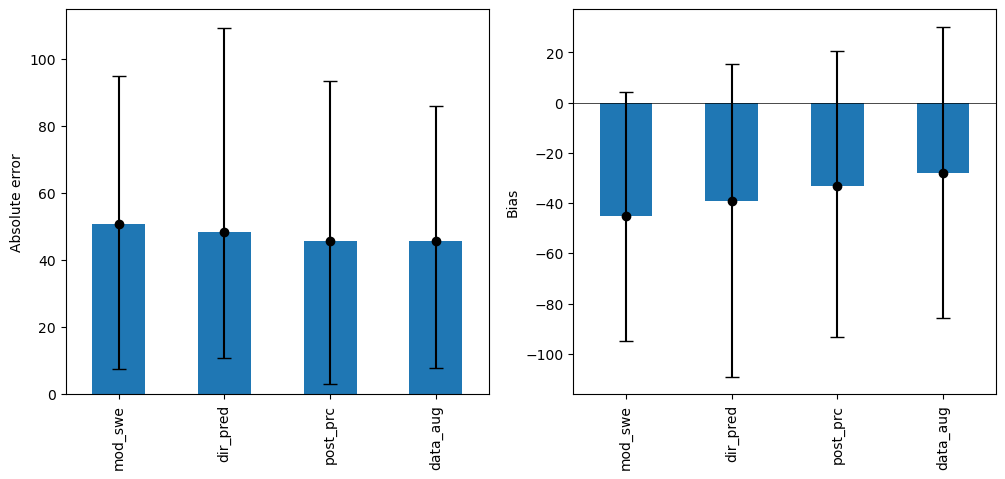

In [105]:
# Get the designated metrics for each column and store it in a new df
metrics = {'Absolute error': absolute_error, 'Bias': bias,}
df_metrics = pd.DataFrame(index=df_peak_swe.columns[1:])
for column in df_peak_swe.columns[1:]:
    for metric_name, function in metrics.items():
        metric = function(df_peak_swe[column], df_peak_swe['obs_swe'])
        df_metrics.loc[column, f"Mean {metric_name}"] = metric.mean()
        df_metrics.loc[column, f"10-Q {metric_name}"] = metric.quantile(0.10)
        df_metrics.loc[column, f"90-Q {metric_name}"] = metric.quantile(0.90)

# Make a bar plot of the mean error
fig, axs = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 5))

for ax, metric_name in zip(axs, metrics.keys()):

    # Plot the mean metric
    df_metrics[f"Mean {metric_name}"].plot(kind='bar', ax=ax)
    ax.set_ylabel(metric_name)

    # Add a horizontal line at 0 if the metric is a bias
    if 'bias' in metric_name.lower():
        ax.axhline(0, color='black', linewidth=0.5)

    # Add the min and max values as error bars
    if plot_quantiles:
        ax.errorbar(df_metrics.index, df_metrics[f"Mean {metric_name}"],
                    yerr=[df_metrics[f"Mean {metric_name}"] - df_metrics[f"10-Q {metric_name}"],
                        df_metrics[f"90-Q {metric_name}"] - df_metrics[f"Mean {metric_name}"]],
                    fmt='o', color='black', capsize=5)

plt.show()

### Predicted and observed SWE

In [5]:
temporal_split = False

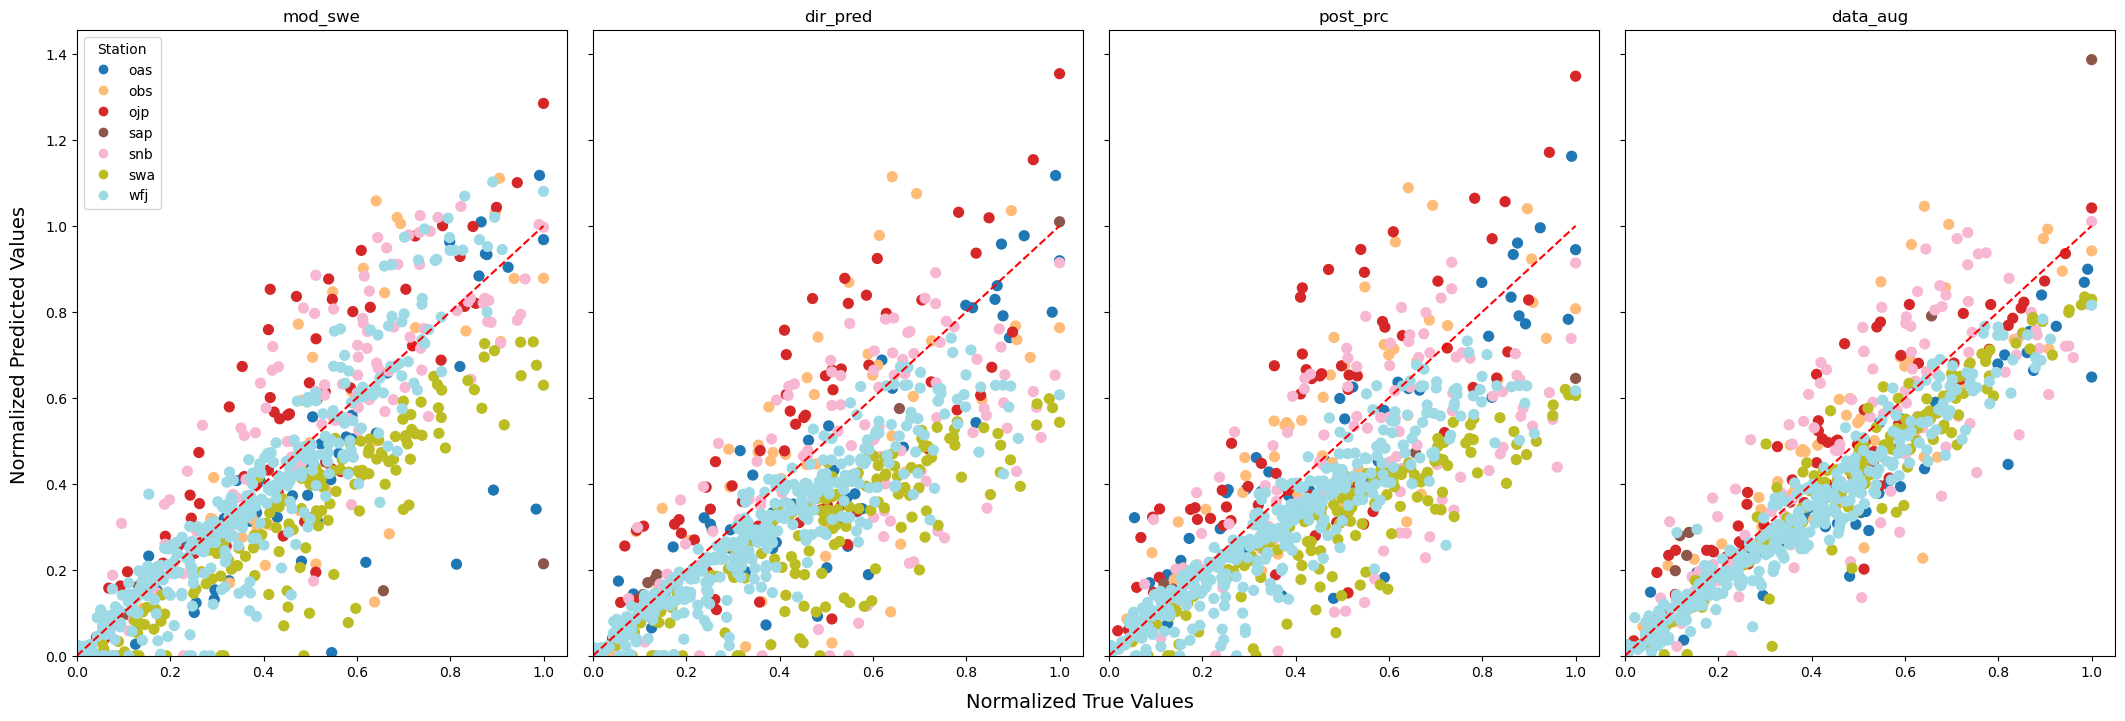

In [ ]:
import matplotlib.pyplot as plt

# Gather the data for all test stations and the selected mode
if temporal_split:
    dict_test = {station_name: tmp_dict_dfs[station_name] for station_name in cfg.trn_stn}
else:
    dict_test = {station_name: stn_dict_dfs[station_name] for station_name in cfg.tst_stn}

# Normalize the SWE values for each station
normalized_data = []
for station, df in dict_test.items():
    peak = df['obs_swe'].max()
    normalized_df = df.copy()
    for col in df.columns:
        if col != 'obs_swe':
            normalized_df[col] /= max_swe
    normalized_df['obs_swe'] /= max_swe
    normalized_df['station'] = station
    normalized_data.append(normalized_df)

# Combine the normalized data
df_test_stations_mode = pd.concat(normalized_data)
df_test_stations_mode = df_test_stations_mode.dropna()

# Get the list of modes 
modes = ['mod_swe'] + list(cfg.modes().keys())

# Drop the cro_vars mode
modes.remove('cro_vars')

# Create subplots
fig, axs = plt.subplots(1, len(modes), figsize=(21, 7), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, mode) in enumerate(zip(axs, modes)):
    scatter = ax.scatter(df_test_stations_mode['obs_swe'], df_test_stations_mode[mode], 
                         c=df_test_stations_mode['station'].astype('category').cat.codes,
                         cmap='tab20', s=50, edgecolor=None)
    
    # Add a line for perfect prediction
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_title(f'{mode}')

    # If it is the first subplot, add a legend
    if i == 0:
        ax.legend(handles=scatter.legend_elements()[0], labels=dict_test.keys(), title='Station')

# Add a general label for the axes
fig.text(0.5, -0.01, 'Normalized True Values', ha='center', va='center', fontsize=14)
fig.text(-0.005, 0.5, 'Normalized Predicted Values', ha='center', va='center', rotation='vertical', fontsize=14)

# Add a legend for the station names
axs[0].legend(handles=scatter.legend_elements()[0], labels=dict_test.keys(), title='Station')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Set the origin to be at (0, 0)
ax.set_xlim(0)
ax.set_ylim(0)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

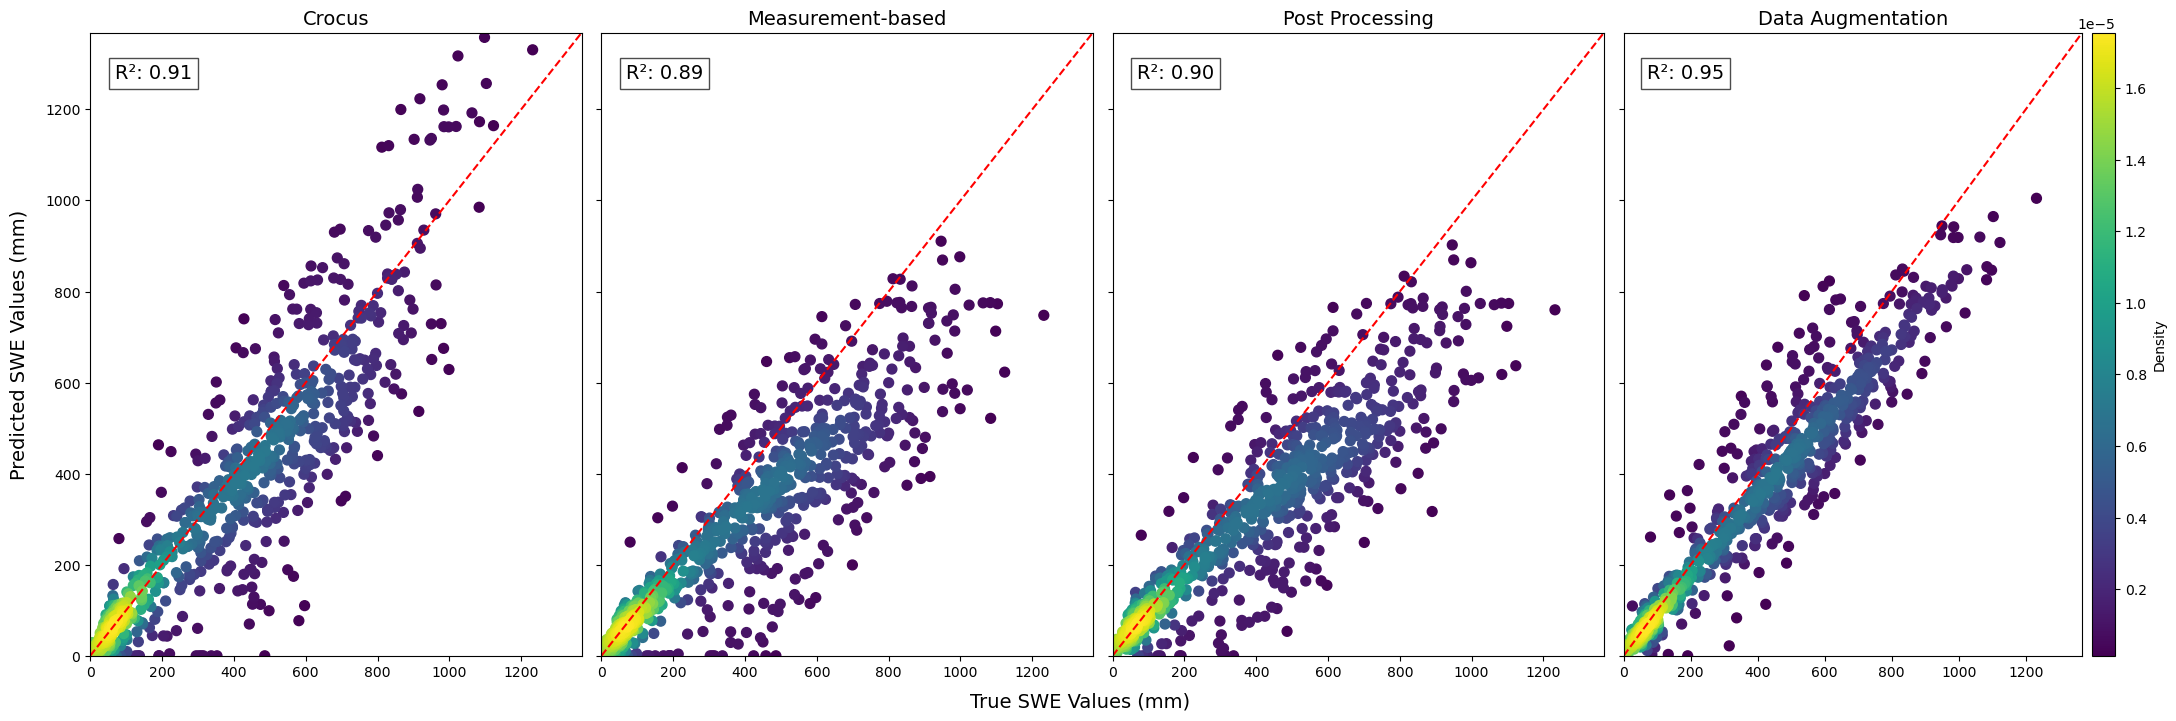

In [10]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming dict_dfs and cfg are already defined

# Gather the data for all test stations and the selected mode
if cfg.temporal_split:
    dict_test = {station_name: tmp_dict_dfs[station_name] for station_name in cfg.trn_stn}
else:
    dict_test = {station_name: stn_dict_dfs[station_name] for station_name in cfg.tst_stn}

# Combine the data without normalizing
df_test_stations_mode = pd.concat(dict_test.values())
df_test_stations_mode = df_test_stations_mode.dropna()

# Get the list of modes
modes = ['mod_swe'] + list(cfg.modes().keys())

# Remove the 'cro_vars' mode
modes.remove('cro_vars')

# Make a dict to rename the modes
rename_dict = {'mod_swe': 'Crocus', 'dir_pred': 'Measurement-based',
               'post_prc': 'Post Processing', 'data_aug': 'Data Augmentation'}
modes = [rename_dict[mode] for mode in modes]
df_test_stations_mode = df_test_stations_mode.rename(columns=rename_dict)

# Create subplots
fig, axes = plt.subplots(1, len(modes), figsize=(21, 7), sharex=True, sharey=True)
axes = axes.flatten()

# Determine the common axis limits
max_val = max(df_test_stations_mode['obs_swe'].max(), df_test_stations_mode[modes].max().max()) + 10

for i, mode in enumerate(modes):
    ax = axes[i]
    
    # Calculate the point density
    xy = np.vstack([df_test_stations_mode['obs_swe'], df_test_stations_mode[mode]])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = df_test_stations_mode['obs_swe'].values[idx], df_test_stations_mode[mode].values[idx], z[idx]

    # Create the scatter plot
    scatter = ax.scatter(x, y, c=z, s=50, edgecolor=None, cmap='viridis')

    # Add a line for perfect prediction
    ax.plot([0, max_val], [0, max_val], color='red', linestyle='--')

    # Calculate the correlation coefficient
    corr = np.corrcoef(x, y)[0, 1]
    ax.text(0.05, 0.95, f'R²: {corr:.2f}', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    
    # Set the same limits for all axes
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)

    # Set the title
    ax.set_title(f'{mode}', fontsize=14)

# Add a general label for the axes
fig.text(0.5, -0.01, 'True SWE Values (mm)', ha='center', va='center', fontsize=14)
fig.text(-0.005, 0.5, 'Predicted SWE Values (mm)', ha='center', va='center', rotation='vertical', fontsize=14)

# Adjust layout
plt.tight_layout()

# Create a divider for the last axis instance
divider = make_axes_locatable(axes[-1])

# Append a new axis to the right of the current axis
cax = divider.append_axes("right", size="5%", pad=0.1)

# Create the colorbar
plt.colorbar(scatter, cax=cax, label='Density')

# Show the plot
plt.show()

#### Augmented and Crocus SWE

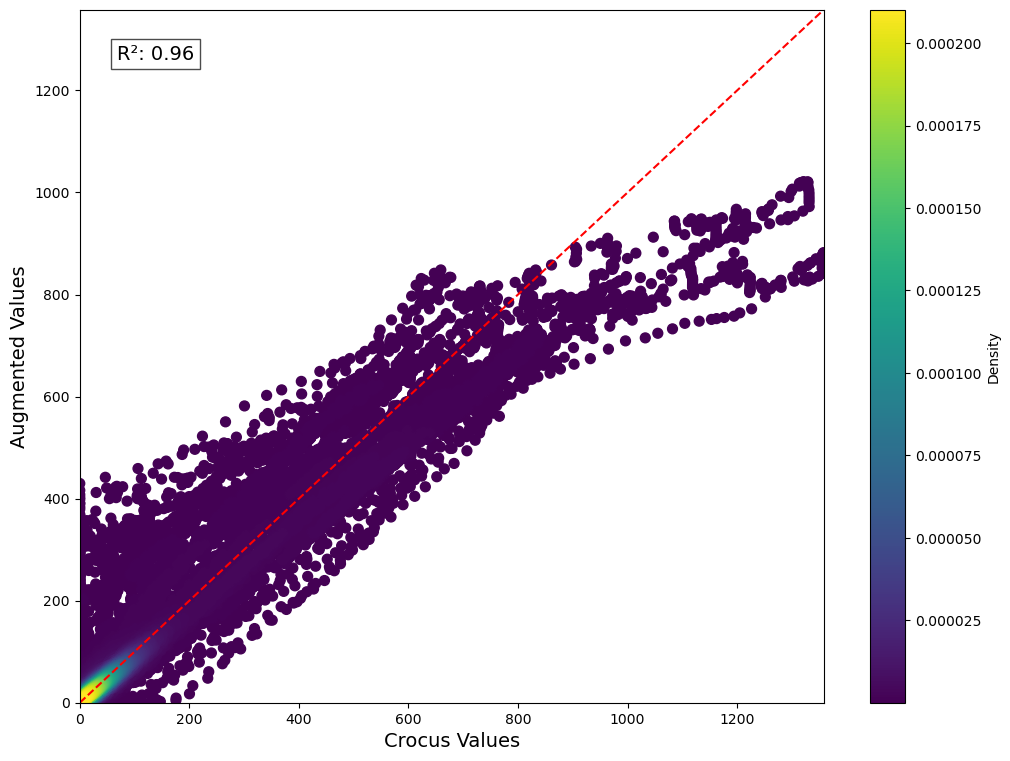

In [13]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Gather the data for all test stations
df_test = pd.concat([stn_dict_dfs[station_name] for station_name in cfg.tst_stn])

# Select the columns of interest and clean the data
df_test = df_test[[f'mod_swe', 'data_aug']].dropna()

# Calculate the point density
xy = np.vstack([df_test['mod_swe'], df_test['data_aug']])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = df_test['mod_swe'].values[idx], df_test['data_aug'].values[idx], z[idx]

# Create the scatter plot
plt.figure(figsize=(12, 9))
plt.scatter(x, y, c=z, s=50, edgecolor=None, cmap='viridis')

# Add a line for perfect prediction, set x and y limits
plt.plot([min(x), max(x)], [min(x), max(x)], color='red', linestyle='--')

# Add labels and title
plt.xlabel('Crocus Values', fontsize=14)
plt.ylabel('Augmented Values', fontsize=14)

# Calculate the correlation coefficient
corr = np.corrcoef(x, y)[0, 1]
plt.text(0.05, 0.95, f'R²: {corr:.2f}', transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Set the axis limits
plt.xlim(min(x.min(), y.min()), max(x.max(), y.max()))
plt.ylim(min(x.min(), y.min()), max(x.max(), y.max()))

# Show the plot
plt.colorbar(label='Density')
plt.show()

### Snow cover timing

In [ ]:
# Gather the data for all test stations
dict_test = {station_name: tmp_dict_dfs[station_name] for station_name in cfg.trn_stn}

# Keep only the columns of interest
for station in dict_test.keys():
    columns = ['obs_swe', 'mod_swe', 'dir_pred', 'post_prc', 'data_aug']
    dict_test[station] = dict_test[station][columns]

# Compute the daily change in SWE for each station
dswe_accumulation = [[]] * len(columns) 
dswe_ablation = [[]] * len(columns) 
dates_peak = []
dates_start = []
dates_end = []
for station, df in dict_test.items():

    # Shift the index 6 months back
    df.index = df.index - pd.DateOffset(months=6)

    # Remove the rows for which the year is not complete
    df_yearly_count = df.groupby(df.index.year).count()
    valid_condition = (df_yearly_count['obs_swe'] > 50) & (df_yearly_count['mod_swe'] > 200)
    valid_years = df_yearly_count.index[valid_condition]
    df = df.loc[df.index.year.isin(valid_years)]

    # For each year, find the date for which the maximum SWE is reached
    df_yearly_max = df.groupby(df.index.year).idxmax()

    # Append the results to the list
    dates_peak.append(df_yearly_max + pd.DateOffset(months=6))

    # Obtain the daily change in SWE
    df_dswe = df.diff().shift(-1).dropna()
    df = df[:-1].dropna()

    # Copy the yearly_max dataframe to store the build-up and snow melt dates
    df_start_date = df_yearly_max.copy()
    df_end_date = df_yearly_max.copy()

    # Remove the values for the build-up and snow melt dates
    df_start_date[:] = pd.NaT
    df_end_date[:] = pd.NaT

    # Split the data into build-up and snow melt according to the date of maximum SWE
    for year in valid_years:
        for col_idx, column in enumerate(df_dswe.columns):

            # Get the peak SWE date
            df_dswe_year = df_dswe.loc[df_dswe.index.year == year]
            df_year = df.loc[df.index.year == year]
            peak_swe_date = df_yearly_max.loc[year, column]

            # Find the last date with no snow before the max SWE date
            df_year_before = df_year.loc[df_year.index < peak_swe_date]
            zero_swe_before = df_year_before.loc[df_year_before[column] < 1].index
            if zero_swe_before.empty:
                last_zero_swe_before = pd.NaT
            else:
                last_zero_swe_before = zero_swe_before.max()
            
            # Find the first date with no snow after the max SWE date
            df_year_after = df_year.loc[df_year.index >= peak_swe_date]
            zero_swe_after = df_year_after.loc[df_year_after[column] < 1].index
            if zero_swe_after.empty:
                first_zero_swe_after = pd.NaT
            else:
                first_zero_swe_after = zero_swe_after.min()

            # Add the start and end dates to the dataframes
            df_start_date.loc[year, column] = last_zero_swe_before + pd.DateOffset(months=6)
            df_end_date.loc[year, column] = first_zero_swe_after + pd.DateOffset(months=6)

            # Check if the dates are NaT
            if last_zero_swe_before is pd.NaT or first_zero_swe_after is pd.NaT:
                continue

            # Select the accumulation and ablation periods
            accumulation_condition = (df_dswe_year.index >= last_zero_swe_before)
            accumulation_condition &= (df_dswe_year.index < peak_swe_date)
            df_accumulation = df_dswe_year.loc[accumulation_condition]

            ablation_condition = (df_dswe_year.index >= peak_swe_date)
            ablation_condition &= (df_dswe_year.index <= first_zero_swe_after)
            df_ablation = df_dswe_year.loc[ablation_condition]

            # Append the results to the list
            dswe_accumulation[col_idx].append(df_accumulation)
            dswe_ablation[col_idx].append(df_ablation)

    # Append the start and end dates to the list
    dates_start.append(df_start_date)
    dates_end.append(df_end_date)

# Combine the change data
df_accumulation = [pd.concat(dswe) for dswe in dswe_accumulation]
df_ablation = [pd.concat(dswe) for dswe in dswe_ablation]

# Concate the dates data
df_dates_peak = pd.concat(dates_peak, keys=dict_test.keys())
df_dates_start = pd.concat(dates_start, keys=dict_test.keys())
df_dates_end = pd.concat(dates_end, keys=dict_test.keys())

# Find the rows containing missing data in the dates dataframes
mask = df_dates_peak.isna().any(axis=1) | df_dates_start.isna().any(axis=1) | df_dates_end.isna().any(axis=1)

# Apply the mask to the dates dataframes
df_peak_clean = df_dates_peak[~mask]
df_start_clean = df_dates_start[~mask]
df_end_clean = df_dates_end[~mask]

#### Dates error

In [83]:
plot_quantiles = True  # False, True

Years available per station: cdp: 8; rme: 20.


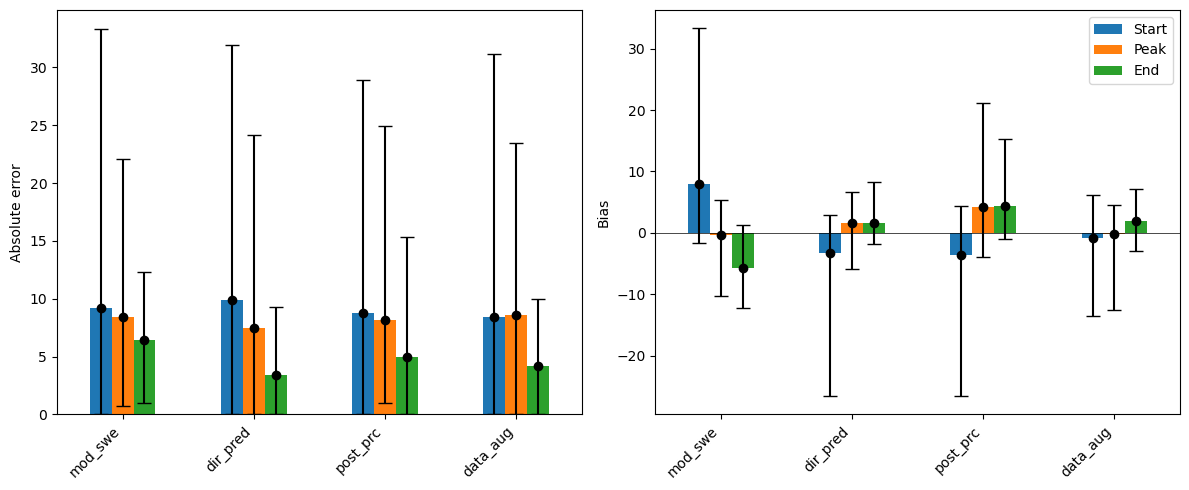

In [ ]:
# Print the number of years used from each station
print("Years available per station:", 
      '; '.join(f'{station}: {count}' for station, count 
                in df_peak_clean.groupby(level=0).size().items()) + '.')

# Define the metrics, modes and features to use
metrics = {'Absolute error': temporal_absolute_error, 'Bias': temporal_bias,}
modes = ['mod_swe', 'dir_pred', 'post_prc', 'data_aug']
features = ['Start', 'Peak', 'End']
dfs_features = [df_start_clean, df_peak_clean, df_end_clean]

# Calculate the metrics for each mode and feature
dfs_metrics = [pd.DataFrame(index=modes) for _ in range(len(metrics))]
for mode in modes:
    for property, df_property in zip(features, dfs_features):
        for df_metric, function in zip(dfs_metrics, metrics.values()):
            metric = function(df_property[mode], df_property['obs_swe'])
            df_metric.loc[mode, f"Mean {property}"] = metric.mean()
            df_metric.loc[mode, f"10-Q {property}"] = metric.quantile(0.10)
            df_metric.loc[mode, f"90-Q {property}"] = metric.quantile(0.90)
# Make a bar plot of the metrics
fig, axs = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 5))

for ax, (metric_name, df_metric) in zip(axs, zip(metrics.keys(), dfs_metrics)):

    # Plot the mean metric
    mean_df = df_metric.filter(like='Mean').rename(columns=lambda x: x.split()[-1])
    bars = mean_df.plot(kind='bar', ax=ax)
    ax.set_ylabel(metric_name)

    # Remove the legend if not the nth subplot
    if ax != axs[1]:
        ax.get_legend().remove()

    # Add a horizontal line at 0 if the metric is a bias
    if 'bias' in metric_name.lower():
        ax.axhline(0, color='black', linewidth=0.5)

    # Add the min and max values as error bars for each feature
    if plot_quantiles:
        # Get the x-positions of the bars
        x_positions = {}
        for i, container in enumerate(ax.containers):
            for j, bar in enumerate(container):
                feature = features[i]
                mode = df_metric.index[j]
                x_pos = bar.get_x() + bar.get_width()/2
                if mode not in x_positions:
                    x_positions[mode] = {}
                x_positions[mode][feature] = x_pos
        
        # Plot error bars at the exact position of each bar
        for i, property in enumerate(features):
            for j, mode in enumerate(df_metric.index):
                ax.errorbar(x_positions[mode][property], df_metric.loc[mode, f"Mean {property}"],
                           yerr=[[df_metric.loc[mode, f"Mean {property}"] - df_metric.loc[mode, f"10-Q {property}"]],
                                [df_metric.loc[mode, f"90-Q {property}"] - df_metric.loc[mode, f"Mean {property}"]]],
                           fmt='o', capsize=5, color='black', elinewidth=1.5)

        # Make the x-axis labels in 45 degrees and right align them
        ax.tick_params(axis='x', rotation=45)
        ax.set_xticklabels(ax.get_xticklabels(), ha='right')

# Set a tight layout and show the plot
plt.tight_layout()
plt.show()

#### Duration error

In [ ]:
plot_quantiles = True  # False, True

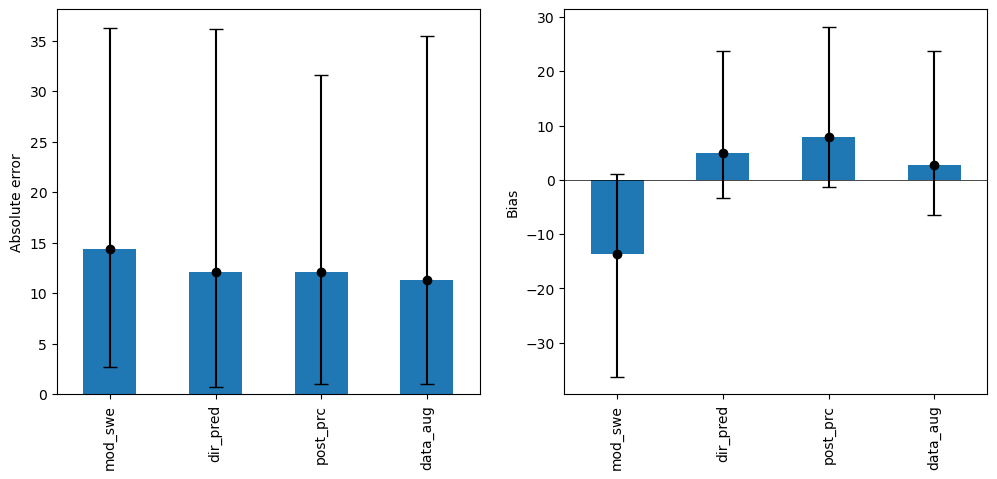

In [107]:
# Calculate the duration of the snow cover
df_duration = df_end_clean - df_start_clean

# Define the metrics to use
metrics = {'Absolute error': temporal_absolute_error, 'Bias': temporal_bias,}
df_metrics = pd.DataFrame(columns=df_duration.columns[1:])
# Calculate the metrics for each property
for column in df_duration.columns[1:]:
    for metric_name, function in metrics.items():
        metric = function(df_duration[column], df_duration['obs_swe'])
        df_metrics.loc[column, f"Mean {metric_name}"] = metric.mean()
        df_metrics.loc[column, f"10-Q {metric_name}"] = metric.quantile(0.10)
        df_metrics.loc[column, f"90-Q {metric_name}"] = metric.quantile(0.90)

# Make a bar plot of the mean error
fig, axs = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 5))

for ax, metric_name in zip(axs, metrics.keys()):

    # Plot the mean metric
    df_metrics[f"Mean {metric_name}"].plot(kind='bar', ax=ax)
    ax.set_ylabel(metric_name)

    # Add a horizontal line at 0 if the metric is a bias
    if 'bias' in metric_name.lower():
        ax.axhline(0, color='black', linewidth=0.5)

    # Add the min and max values as error bars
    if plot_quantiles:
        ax.errorbar(df_metrics.index, df_metrics[f"Mean {metric_name}"],
                    yerr=[df_metrics[f"Mean {metric_name}"] - df_metrics[f"10-Q {metric_name}"],
                        df_metrics[f"90-Q {metric_name}"] - df_metrics[f"Mean {metric_name}"]],
                    fmt='o', color='black', capsize=5)

plt.show()
    

#### Accumulation and ablation

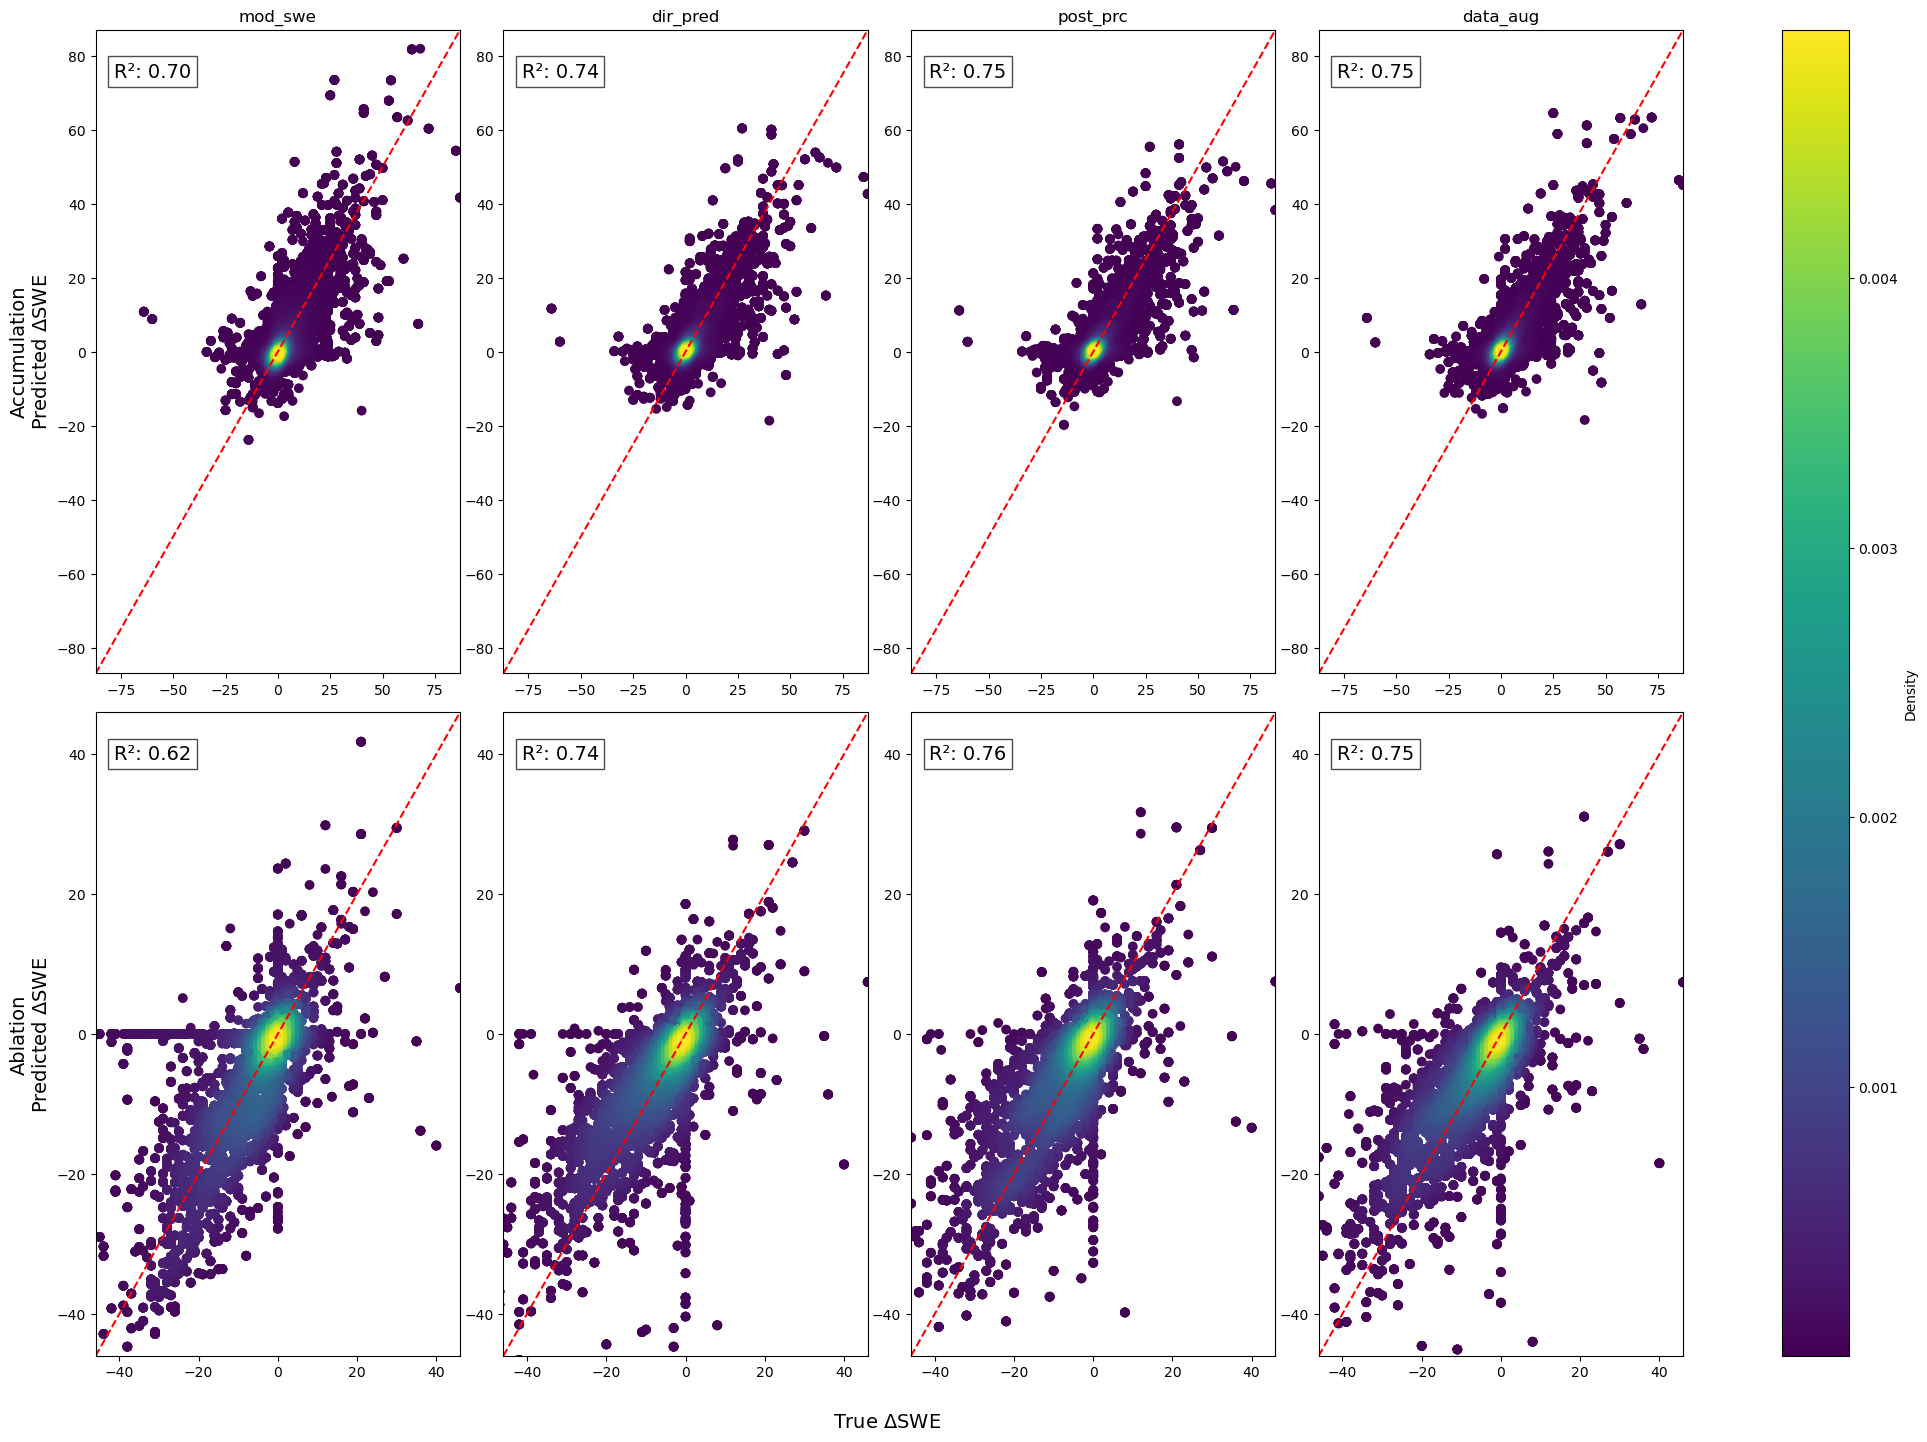

In [116]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Get the list of modes
modes = ['mod_swe'] + list(cfg.modes().keys())

# Remove the 'cro_vars' mode
modes.remove('cro_vars')

# Create subplots with 2 rows and len(modes) columns
fig, axes = plt.subplots(2, len(modes), figsize=(21, 14))
axes = axes.flatten()

# Plot for df_accumulation
for i, mode in enumerate(modes):
    ax = axes[i]
    
    # Calculate the point density
    xy = np.vstack([df_accumulation[i]['obs_swe'], df_accumulation[i][mode]])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = df_accumulation[i]['obs_swe'].values[idx], df_accumulation[i][mode].values[idx], z[idx]

    # Create the scatter plot
    scatter = ax.scatter(x, y, c=z, s=50, edgecolor='none', cmap='viridis')

    # Add a line for perfect prediction
    max_val = max(df_accumulation[i]['obs_swe'].max(), df_accumulation[i][mode].max())
    ax.plot([-max_val, max_val], [-max_val, max_val], color='red', linestyle='--')
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val, max_val)
        
    # Add labels and title
    if i == 0:
        ax.set_ylabel('Accumulation\nPredicted $\Delta$SWE', fontsize=14)
    ax.set_title(f'{mode}')

    # Calculate the correlation coefficient
    corr = np.corrcoef(x, y)[0, 1]
    ax.text(0.05, 0.95, f'R²: {corr:.2f}', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Plot for df_ablation
for i, mode in enumerate(modes):
    ax = axes[len(modes) + i]
    
    # Calculate the point density
    xy = np.vstack([df_ablation[i]['obs_swe'], df_ablation[i][mode]])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = df_ablation[i]['obs_swe'].values[idx], df_ablation[i][mode].values[idx], z[idx]

    # Create the scatter plot
    scatter = ax.scatter(x, y, c=z, s=50, edgecolor='none', cmap='viridis')

    # Add a line for perfect prediction
    max_val = max(df_ablation[i]['obs_swe'].max(), df_ablation[i][mode].max())
    ax.plot([-max_val, max_val], [-max_val, max_val], color='red', linestyle='--')
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val, max_val)
    
    # Add y label if it is the first column
    if i == 0:
        ax.set_ylabel('Ablation\nPredicted $\Delta$SWE', fontsize=14)

    # Calculate the correlation coefficient
    corr = np.corrcoef(x, y)[0, 1]
    ax.text(0.05, 0.95, f'R²: {corr:.2f}', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add a label for the x axis
fig.text(0.425, -0.02, 'True $\Delta$SWE', ha='center', va='center', fontsize=14)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.colorbar(scatter, ax=axes, label='Density')
plt.show()

### Positive dSWE and snowfall

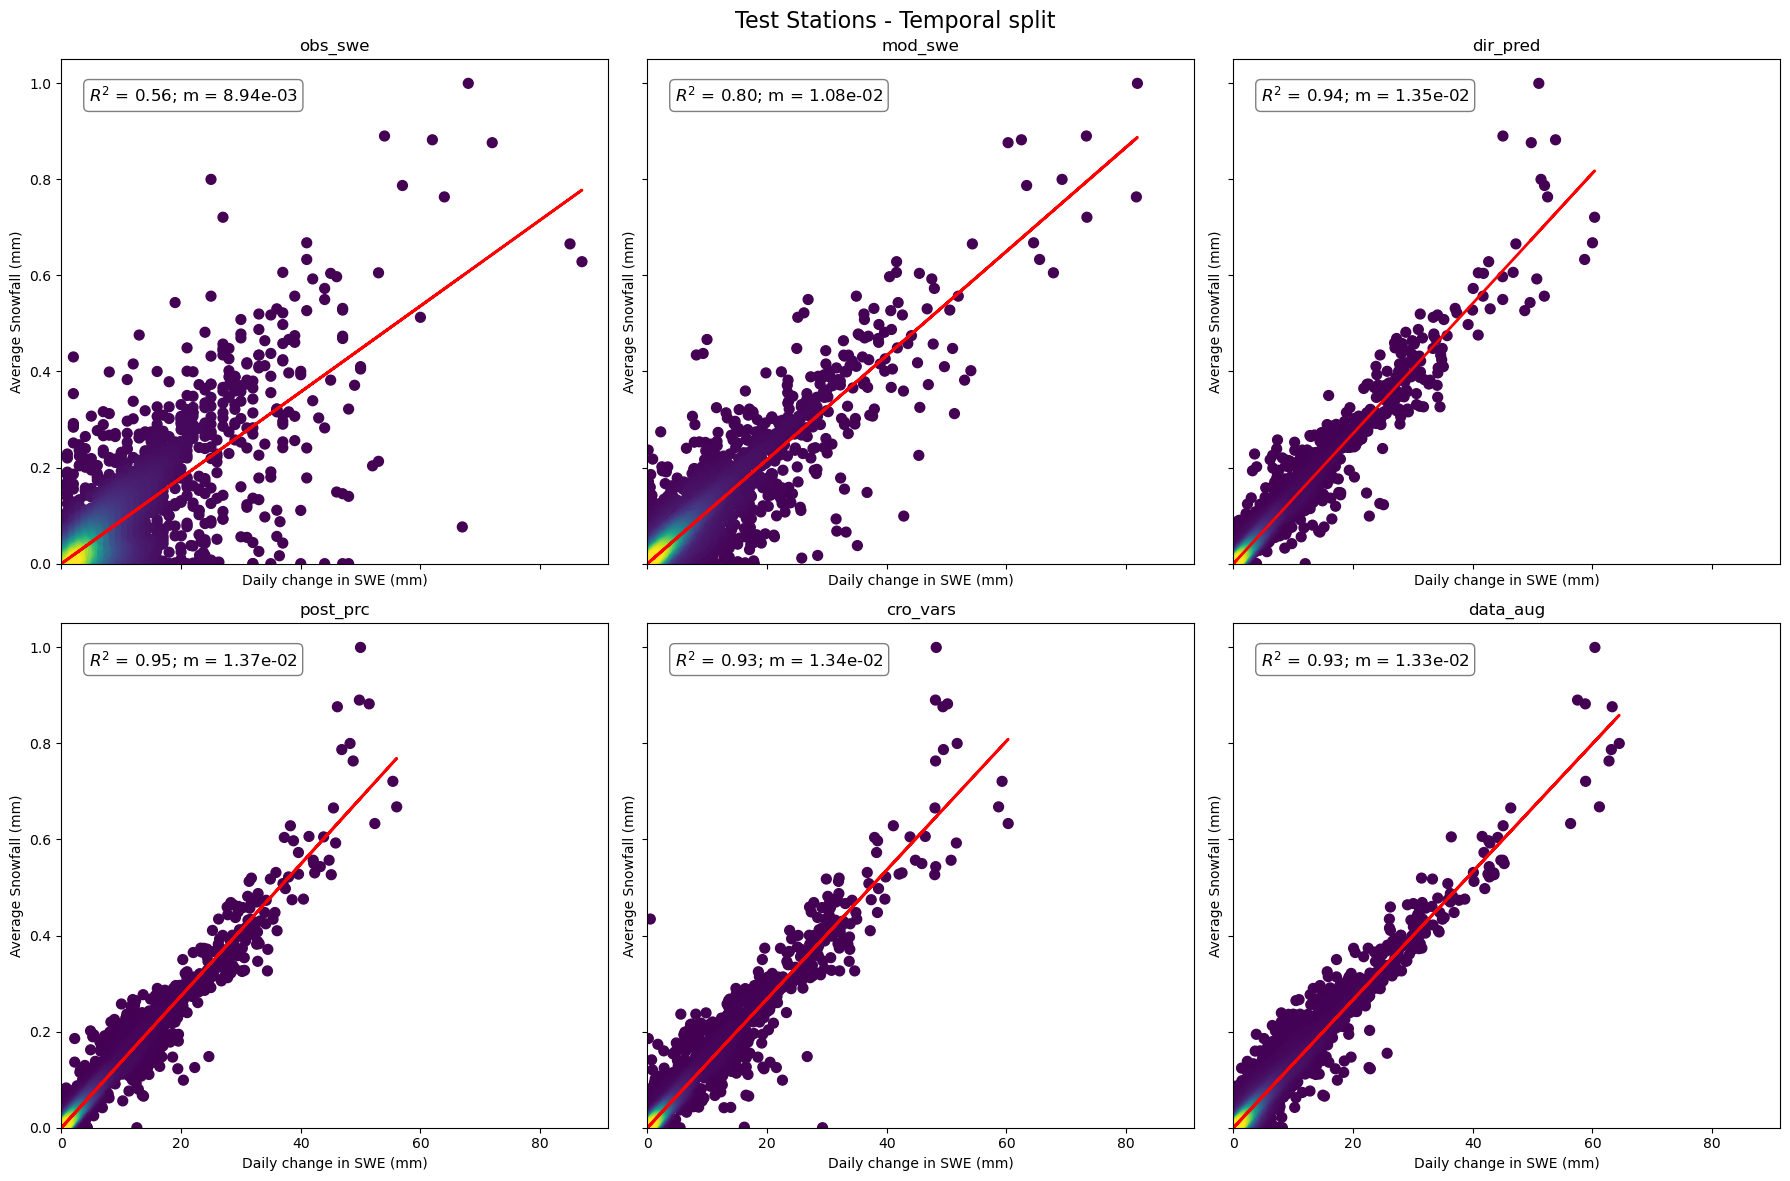

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# Gather the data for all test stations and the selected mode
dict_test = {station_name: tmp_dict_dfs[station_name].copy() for station_name in cfg.trn_stn}

# Get the list of modes + obs_swe
ignore_cols = ['station', 'met_Snowf_avg', 'met_Tair_avg']
modes = [col for col in list(dict_test.values())[0].columns if col not in ignore_cols]

# Convert each column to the daily change in SWE
for station_name, df in dict_test.items():
    for col in modes:
        df[col] = df[col].diff().shift(-1)
    dict_test[station_name] = df[:-1]

# Combine the data and drop NaN values
df_test_stations_mode = pd.concat(dict_test.values())
df_test_stations_mode = df_test_stations_mode.dropna()

# Create subplots
fig, axes = plt.subplots(2, len(modes)//2, figsize=(18, 12), sharey=True, sharex=True)
axes = axes.flatten()

for i, mode in enumerate(modes):
    ax = axes[i]
    
    # Calculate the change in SWE and the snowfall
    dswe = df_test_stations_mode[mode]
    snowf = df_test_stations_mode['met_Snowf_avg']

    # Take only the values that have positive change in SWE
    snowf = snowf[dswe > 0]
    dswe = dswe[dswe > 0]

    # Calculate the point density
    xy = np.vstack([dswe, snowf])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = dswe.values[idx], snowf.values[idx], z[idx]

    # Create the scatter plot
    scatter = ax.scatter(x, y, c=z, s=50, edgecolor=None, cmap='viridis')

    # Fit a linear regression line with an intercept of 0
    A = x[:, np.newaxis]
    slope, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    y_pred = slope * x

    # Calculate R-squared
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Add the regression line to the plot
    ax.plot(x, y_pred, color='red', linewidth=2)

    # Add labels and title
    ax.set_xlabel('Daily change in SWE (mm)')
    ax.set_ylabel('Average Snowfall (mm)')
    ax.set_title(f'{mode}')

    # Add R-squared value inside the plot as a text in a box
    textstr = f'$R^2$ = {r_squared:.2f}; m = {slope[0]:.2e}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    # Set the axis limits
    ax.set_xlim(0)
    ax.set_ylim(0)

# Set the general title
fig.suptitle('Test Stations - Temporal split', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

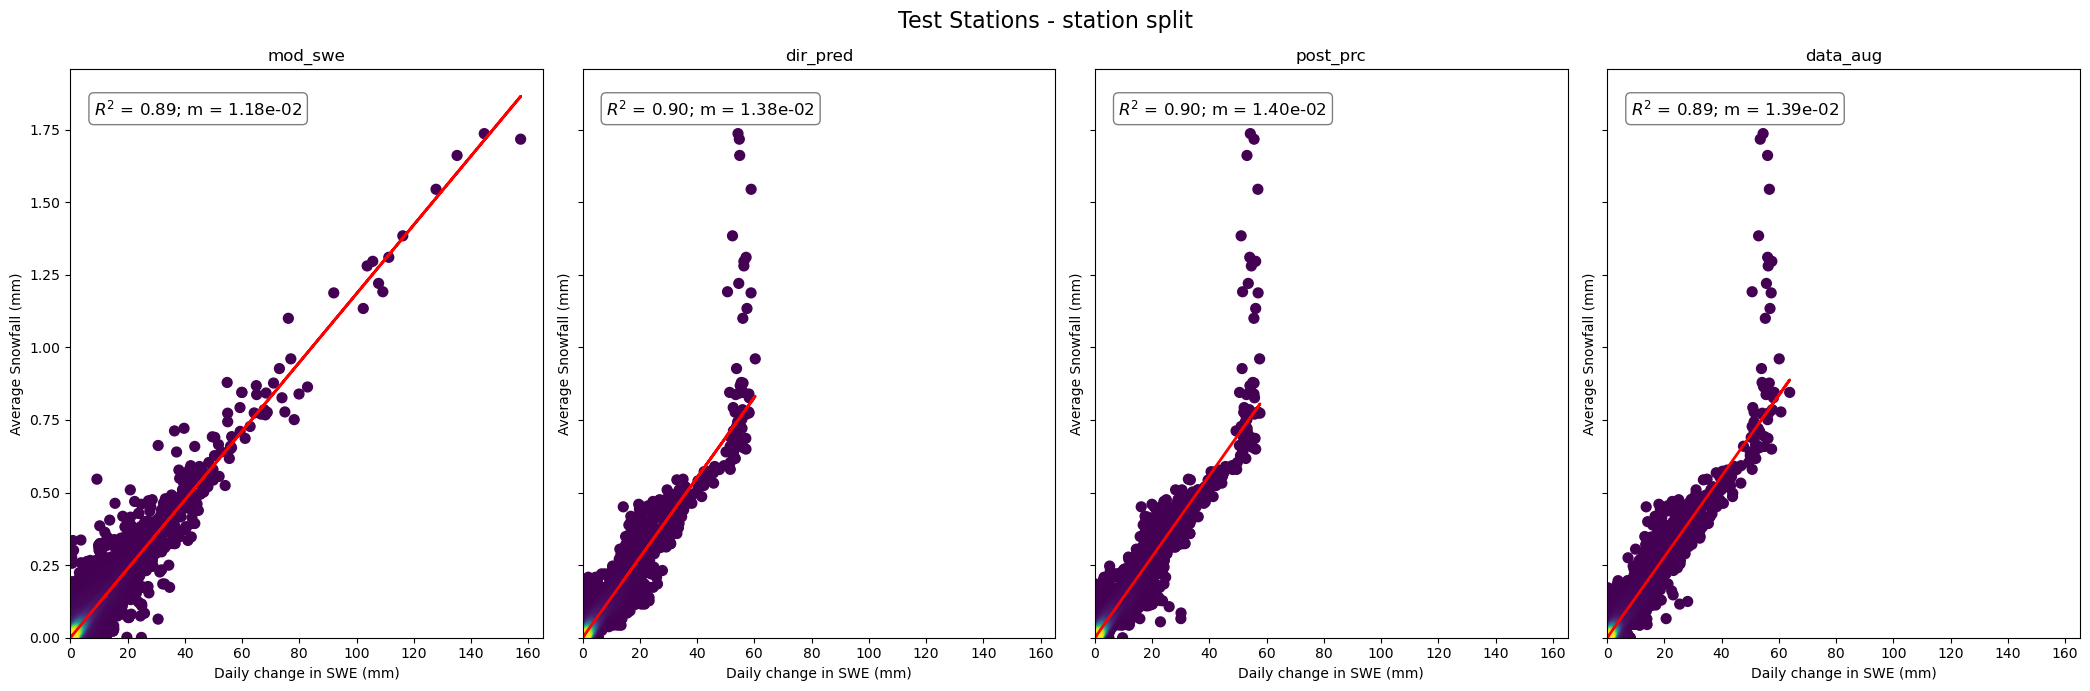

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# Gather the data for all test stations and the selected mode
dict_test = {station_name: stn_dict_dfs[station_name].copy() for station_name in cfg.tst_stn}

# Get the list of modes
modes = ['mod_swe'] + list(cfg.modes().keys())

# Remove the 'cro_vars' mode
modes.remove('cro_vars')

# Convert each column to the daily change in SWE
for station_name, df in dict_test.items():
    for col in modes:
        df[col] = df[col].diff().shift(-1)
    dict_test[station_name] = df[:-1]

# Combine the data and drop NaN values for the non-measured columns
df_test = pd.concat(dict_test.values())
df_test = df_test.dropna(subset=modes)

# Create subplots
fig, axes = plt.subplots(1, len(modes), figsize=(21, 7), sharey=True, sharex=True)

for i, mode in enumerate(modes):
    ax = axes[i]
    
    # Calculate the change in SWE and the snowfall
    dswe = df_test[mode]
    snowf = df_test['met_Snowf_avg']

    # Take only the values that have positive change in SWE
    snowf = snowf[dswe > 0]
    dswe = dswe[dswe > 0]

    # Calculate the point density
    xy = np.vstack([dswe, snowf])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = dswe.values[idx], snowf.values[idx], z[idx]

    # Create the scatter plot
    scatter = ax.scatter(x, y, c=z, s=50, edgecolor=None, cmap='viridis')

    # Fit a linear regression line with an intercept of 0
    A = x[:, np.newaxis]
    slope, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    y_pred = slope * x

    # Calculate R-squared
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Add the regression line to the plot
    ax.plot(x, y_pred, color='red', linewidth=2)

    # Add labels and title
    ax.set_xlabel('Daily change in SWE (mm)')
    ax.set_ylabel('Average Snowfall (mm)')
    ax.set_title(f'{mode}')

    # Add R-squared value inside the plot as a text in a box
    textstr = f'$R^2$ = {r_squared:.2f}; m = {slope[0]:.2e}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

# Set the axis limits
axes[0].set_xlim(0)
axes[0].set_ylim(0)

# Set the general title
fig.suptitle('Test Stations - station split', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Predicted positive dSWE for null snowfall (test stations - station split)')

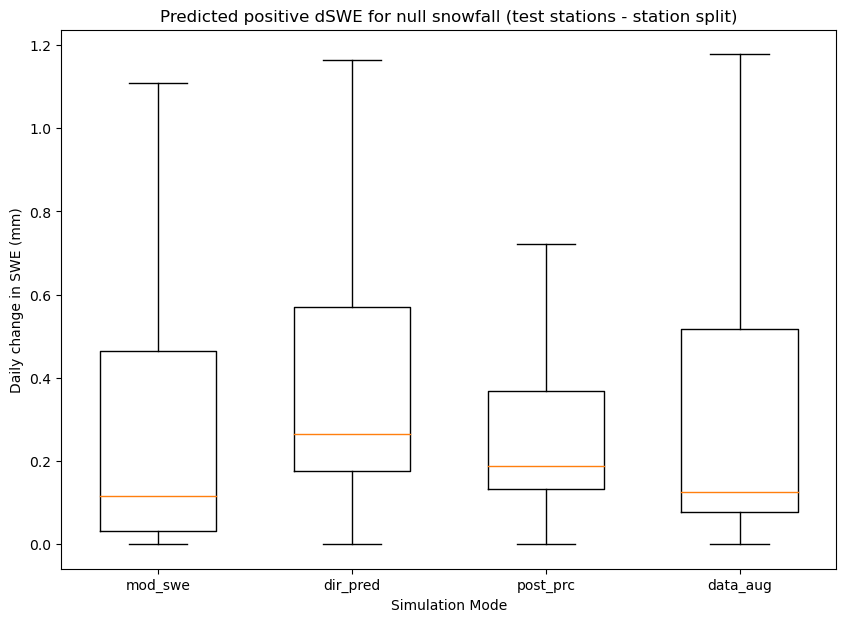

In [49]:
# Make a boxplot of the positive changes in SWE for an average snowfall of 0
fig, ax = plt.subplots(figsize=(10, 7))

# Calculate the change in SWE and the snowfall from df_test
for mode in modes:
    dswe = df_test[mode]
    snowf = df_test['met_Snowf_avg']

    # Take only the values that have positive change in SWE
    snowf = snowf[dswe > 0]
    dswe = dswe[dswe > 0]

    # Take only the values with snowfall of 0
    dswe = dswe[snowf == 0]

    # Add the data to the boxplot
    ax.boxplot(dswe, positions=[modes.index(mode)], widths=0.6, showfliers=False, labels=[mode])

# Add labels and title
ax.set_xlabel('Simulation Mode')
ax.set_ylabel('Daily change in SWE (mm)')
ax.set_title('Predicted positive dSWE for null snowfall (test stations - station split)')